In [2]:
#https://ieeexplore.ieee.org/document/9025572
#https://ieeexplore.ieee.org/document/8265477
#https://ieeexplore.ieee.org/search/searchresult.jsp?newsearch=true&queryText=outfit%20recommend
#https://ieeexplore.ieee.org/document/9804781
#https://developers.google.com/public-data/docs/canonical/countries_csv
#https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state
#https://stackoverflow.com/questions/65244102/how-to-get-latitude-and-longitude-from-an-address-scraping-google-maps
#https://geokeo.com/database/county/gb/
#https://simplemaps.com/data/gb-cities
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8628399/
#https://caffeinedev.medium.com/how-to-install-tensorflow-on-m1-mac-8e9b91d93706 tenserflow

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 15 19:50:42 2024

@author: shrutipatkar
"""

import pandas as pd
import numpy as np
#pip install country_converter --upgrade
#import country_converter as coco
import difflib
import pycountry
from geopy.geocoders import Nominatim
import re
from datetime import datetime
from matplotlib import colors
#from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split

#spell = SpellChecker()



In [2]:
df = pd.read_excel("dataset.xlsx")

df.drop(columns=["Timestamp", "Consent Form:\nI have read the description and accompanying Information Sheet relating to the project on Personality Based Outfit Selection System and understand that participation is entirely voluntary and that I have the right to withdraw from the project any time, and that this will be without detriment. This application has been reviewed by the University Research Ethics Committee and has been given a favourable ethical opinion for conduct.", "Please read the document carefully and proceed with th consent form."], inplace=True)


# dictionary to map the current column names to new names
new_column_names = {
    'Country of Birth': 'Country_of_Birth',
    'Country of Residence': 'Country_of_Residence',
    'Birthdate': 'Birthdate',
    'Gender': 'Gender',
    'Approximate weight in kilogram': 'Weight_kg',
    'Approximate height in centimetre': 'Height_cm',
    'What type of clothes you prefer to wear': 'Preferred_Clothing_Type',
    'How do you define yourself': 'Personality',
    'Size of clothes you wear': 'Clothing_Size',
    'What is your favourite color.': 'Favourite_Color',
    'Do you think this color looks best on you and boost your confidence?': 'Color_Boost_Confidence',
    'Which color do you think looks best on you and makes you feel confident?': 'Best_Color_Confidence',
    'What type of clothing you like to wear': 'Preferred_Clothing',
    'What is your preferred bottoms': 'Preferred_Bottoms',
    'Material preferred for your bottoms?': 'Bottoms_Material',
    'Length of bottoms you prefer?': 'Bottoms_Length',
    'How do you prefer the fitting of your bottoms?': 'Bottoms_Fitting',
    'Which color of bottoms would you prefer. (Please mention two colours)': 'Bottoms_Color',
    'Any other specific detail about the bottoms you will like to mention?': 'Bottoms_Other_Details',
    'What is your prefered upperwear on the selected bottoms?': 'Preferred_Upperwear',
    'What material you will prefer for the upperwear?': 'Upperwear_Material',
    'What length of upperwear would you choose?': 'Upperwear_Length',
    'What is your prefered neckline for them?': 'Upperwear_Neckline',
    'What is your preferred sleeve type?': 'Upperwear_Sleeve_Type',
    'What pattern will you like on you upperwear?': 'Upperwear_Pattern',
    'which type of print': 'Upperwear_Print_Type',
    'What is your preferred color for the selected upperwear to go on the selected bottoms?Please select two)': 'Upperwear_Color',
    'Any other specific detail about the upper wear?': 'Upperwear_Other_Details',
    'Favourite type of single piece wear': 'Favourite_Single_Piece',
    'What is your preferred material?': 'Single_Piece_Material',
    'How do you prefer the fitting?': 'Single_Piece_Fitting',
    'What is your preferred length?': 'Single_Piece_Length',
    'How will you prefer your sleeves?': 'Single_Piece_Sleeves',
    'How would you prefer your neckline?': 'Single_Piece_Neckline',
    'What is your preferred pattern?': 'Single_Piece_Pattern',
    'which type of print.1': 'Single_Piece_Print_Type',
    'Would you prefer the colour which you have mentioned in previous section?': 'Single_Piece_Preferred_Color',
    'What color would you like to choose for you single piece wear': 'Single_Piece_Color',
    'Any other specific detail about the clothing?': 'Clothing_Other_Details',
    'Do you like to wear outer layer on top?': 'Outer_Layer_Preference',
    'What type of outer layer you prefer to wear': 'Preferred_Outer_Layer',
    'What is your preferred material?.1': 'Outer_Layer_Material',
    'How do you prefer the fitting?.1': 'Outer_Layer_Fitting',
    'What is your preferred length?.1': 'Outer_Layer_Length',
    'How will you prefer your sleeves?.1': 'Outer_Layer_Sleeves',
    'How would you prefer your neckline?.1': 'Outer_Layer_Neckline',
    'Type of closing ': 'Outer_Layer_Closing_Type',
    'What color would you like to choose?': 'Outer_Layer_Color',
    'What is your preferred pattern?.1': 'Outer_Layer_Pattern',
    'which type of print.2': 'Outer_Layer_Print_Type',
    'Any other specific detail about the outer layer?': 'Outer_Layer_Other_Details'
}

# Rename the columns in the DataFrame
df.rename(columns=new_column_names, inplace=True)

df.loc[df['Country_of_Residence'] == 'Same as Country of Birth', 'Country_of_Residence'] = df['Country_of_Birth']
df.loc[df['Color_Boost_Confidence'] == 'Yes', 'Best_Color_Confidence'] = df['Favourite_Color']

df.loc[df['Single_Piece_Preferred_Color'] == 'Yes', 'Single_Piece_Color'] = df['Color_Boost_Confidence']

df["Color_Boost_Confidence"].replace({"Yes":1, "No":0}, inplace=True)
df["Country_of_Birth"] = df["Country_of_Birth"].astype(str)
df["Country_of_Residence"] = df["Country_of_Residence"].astype(str)   
df["Country_of_Birth"] = df["Country_of_Birth"].str.strip().str.title()
df["Country_of_Residence"] = df["Country_of_Residence"].str.strip().str.title()

# Create a list of official country names
country_names = [country.name for country in pycountry.countries]
alpha_2_mapping = {country.alpha_2.title(): country.name.title() for country in pycountry.countries}

df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x: x.split(",")[-1] if isinstance(x, str) else x)

df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x: x.split(",")[-1] if isinstance(x, str) else x)


df["Country_of_Birth"] = df["Country_of_Birth"].replace({"Uk":"United Kingdom", 
                                "Usa": "United States",
                                "Us":"United States",
                                "America":"United States",
                                "United States Of America": "United States",
                                "United State Of America" : "United States",
                                "United States Of American":"United States",
                               "England": "United Kingdom",
                               "Wales":"United Kingdom",
                               "Scotland":"United Kingdom",
                               "Ksa": "Saudi Arabia",
                               "Rsa": "South Africa",
                               "Great Britain":"United Kingdom",
                               "Britain": "United Kingdom",
                               "Uae":"United Arab Emirates",
                               "United Kingdom Of Great Britain And Northern Ireland":"United Kingdom",
                            "Mumbai":"India",
                            "Czechia": "Czech Republic",
                            "Bharat":"India",
                            "Edinburgh":"United Kingdom",
                            "Korea":"South Korea",
                            "Russian Federation": "Russia",
                            "Thane":"India",
                            "Dubai": "United Arab Emirates",
                            "Democratic Republic Of Congo": "Congo",
                            "Europe":"United Kingdom"})

df["Country_of_Residence"] = df["Country_of_Residence"].replace({"Uk":"United Kingdom", 
                                "Usa": "United States",
                                "Us":"United States",
                                "America":"United States",
                                "United States Of America": "United States",
                                "United State Of America" : "United States",
                                "United States Of American":"United States",
                               "England": "United Kingdom",
                               "Wales":"United Kingdom",
                               "Scotland":"United Kingdom",
                               "Ksa": "Saudi Arabia",
                               "Rsa": "South Africa",
                               "Great Britain":"United Kingdom",
                               "Britain": "United Kingdom",
                               "Uae":"United Arab Emirates",
                               "United Kingdom Of Great Britain And Northern Ireland":"United Kingdom",
                            "Mumbai":"India",
                            "Czechia": "Czech Republic",
                            "Bharat":"India",
                            "Edinburgh":"United Kingdom",
                            "Korea":"South Korea",
                            "Russian Federation": "Russia",
                            "Thane":"India",
                            "Dubai": "United Arab Emirates",
                            "Democratic Republic Of Congo": "Congo",
                            "Europe":"United Kingdom"})




# Replace blank, NaN, or unreadable entries in 'Country_of_Birth' with 'Country_of_Residence'
df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x: np.nan if isinstance(x, str) and x.strip() in ['', 'Cannot Read Text'] else x)
df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x: np.nan if isinstance(x, str) and x.strip() in ['', 'Cannot Read Text'] else x)

df["Country_of_Birth"].fillna(df["Country_of_Residence"], inplace=True)
df["Country_of_Residence"].fillna(df["Country_of_Birth"], inplace=True)


# Function to find the best match and its confidence
def get_best_match_with_confidence(country):
    country = country.replace("City", "")
    if "Englan" in country:
        country = "United Kingdom"
    if "rkiye" in country and country.startswith("T"):
        country = "Turkey"
    try:
        try:
            country = alpha_2_mapping[country]
        except:
            pass
        matches = difflib.get_close_matches(country, country_names, n=1)
        if matches:
            best_match = matches[0]
            confidence = difflib.SequenceMatcher(None, country, best_match).ratio()
            if confidence >= 0.80:
                return best_match, confidence
            else:
                return country, 0
        else:
            return country, 0
    except:
        return country, 0

# Get the unique values from the 'Country_of_Birth' column
unique_countries_1 = list(df['Country_of_Birth'].unique())
unique_countries_2 = list(df['Country_of_Residence'].unique())
unique_countries = np.union1d(unique_countries_1, unique_countries_2)




# Apply the function to the unique values
matched_countries = {country: get_best_match_with_confidence(country) for country in unique_countries}

# Create two new columns in the DataFrame by mapping the results back to the original 'Country_of_Birth' column
df['Country_of_Birth'] = df['Country_of_Birth'].apply(lambda x: matched_countries[x][0] if x in matched_countries else x)
#df['Match_Confidence'] = df['Country_of_Birth'].apply(lambda x: matched_countries[x][1] if x in matched_countries else 0)

df['Country_of_Residence'] = df['Country_of_Residence'].apply(lambda x: matched_countries[x][0] if x in matched_countries else x)

# Create a mapping from country names to numerical values
country_mapping = {country: idx + 1 for idx, country in enumerate(unique_countries)}

# Function to convert country names to numbers
def convert_country_to_number(country):
    return country_mapping.get(country, None)
# Apply the function to the 'Country' column


In [3]:
unique_countries_1 = list(df['Country_of_Birth'].unique())
unique_countries_2 = list(df['Country_of_Residence'].unique())
unique_countries = np.union1d(unique_countries_1, unique_countries_2)
unique_countries

country_map = pd.read_excel("country_to_lat_long.xlsx")
country_map['name'] = country_map['name'].str.strip().str.lower().str.replace(' ', '', regex=True).str.replace(r"\s*\([^()]*\)", "", regex=True)

country_map = country_map.drop_duplicates(subset=['name'])


countries_normalized = np.char.replace(np.char.strip(np.char.lower(unique_countries)), ' ', '')


# Create a dictionary from the DataFrame for quick lookup
country_dict = dict(zip(country_map['name'], zip(country_map['latitude'], country_map['longitude'])))

# Map the countries in the array to their coordinates using the dictionary
coordinates = [country_dict.get(country, (None, None)) for country in countries_normalized]

# Convert to DataFrame for better visualization or further use
coordinates_df = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'], index=unique_countries).reset_index()
coordinates_df.to_csv("test2.csv")

df = df.merge(coordinates_df, left_on='Country_of_Birth', right_on='index')
df.drop(columns=["index", "Country_of_Birth"], inplace=True)
# Rename latitude and longitude columns
df.rename(columns={'Latitude': 'birthplace_lat', 'Longitude': 'birthplace_lon'}, inplace=True)


df = df.merge(coordinates_df, left_on='Country_of_Residence', right_on='index')
df.drop(columns=["index", "Country_of_Residence"], inplace=True)

# Rename latitude and longitude columns
df.rename(columns={'Latitude': 'resi_lat', 'Longitude': 'resi_lon'}, inplace=True)


/Users/shrutipatkar/anaconda3/envs/mlp/lib/python3.8/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [4]:
df['Outer_Layer_Pattern'] = df['Outer_Layer_Pattern'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df['Single_Piece_Pattern'] = df['Single_Piece_Pattern'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df['Upperwear_Pattern'] = df['Upperwear_Pattern'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df = df.explode('Outer_Layer_Pattern')
df = df.explode('Single_Piece_Pattern')
df = df.explode('Upperwear_Pattern')


pattern_1 = list(df['Outer_Layer_Pattern'].unique())
pattern_2 = list(df['Single_Piece_Pattern'].unique())
pattern_3 = list(df['Upperwear_Pattern'].unique())
patterns = np.union1d(pattern_1, pattern_2)
patterns = np.union1d(patterns, pattern_3)

mapping_pattern = {}   
for pattern in patterns:
    i=pattern.lower()
    if pattern not in ['solid color', 'printed', 'stripes vertical','stripes horizontal', "tye die", "polka dots"]:
        if ("solid") in i or (i.startswith("pla")) or ("simple" in i):
            mapping_pattern[pattern] = "solid color"
        elif "print" in i:
            mapping_pattern[pattern] = "printed"
        elif "floral" in i or "flower" in i:
            mapping_pattern[pattern] = "floral printed"
        elif "graphic" in i or "logo" in i or "design" in i or "band" in i or "brand" in i:
            mapping_pattern[pattern] = "graphic printed"
        elif "che" in i or "box" in i or "block" in i or "cube" in i:
            mapping_pattern[pattern] = "box printed"
        elif "animal" in i:
            mapping_pattern[pattern] = "animal printed"
        elif "anime" in i:
            mapping_pattern[pattern] = "anime printed"  
        else:
            mapping_pattern[pattern] = "Not defined"
        
            
df['Outer_Layer_Pattern'] = df['Outer_Layer_Pattern'].replace(mapping_pattern)
df['Single_Piece_Pattern'] = df['Single_Piece_Pattern'].replace(mapping_pattern)
df['Upperwear_Pattern'] = df['Upperwear_Pattern'].replace(mapping_pattern)

In [5]:
df['Upperwear_Print_Type'] = df['Upperwear_Print_Type'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df['Outer_Layer_Print_Type'] = df['Outer_Layer_Print_Type'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df['Single_Piece_Print_Type'] = df['Single_Piece_Print_Type'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
df = df.explode('Upperwear_Print_Type')
df = df.explode('Single_Piece_Print_Type')
df = df.explode('Outer_Layer_Print_Type')


pattern_1 = list(df['Upperwear_Print_Type'].unique())
pattern_2 = list(df['Single_Piece_Print_Type'].unique())
pattern_3 = list(df['Outer_Layer_Print_Type'].unique())
patterns = np.union1d(pattern_1, pattern_2)
patterns = np.union1d(patterns, pattern_3)

mapping_pattern = {}
for pattern in patterns:
    i=str(pattern).lower() 
    if "floral" in i or "flower" in i:
        mapping_pattern[pattern] = "floral printed"
    elif "graphic" in i or "logo" in i or "design" in i or "band" in i or "brand" in i or "image" in i or "mark" in i or "pictur" in i or "3d" in i or "art in i":
        mapping_pattern[pattern] = "graphic printed"
    elif "text" in i or "letter" in i or "sent" in i or "name" in i or "phrase" in i:
        mapping_pattern[pattern] = "text printed"
    elif "abstract" in i or "random" in i or "graffiti" in i:   
        mapping_pattern[pattern] = "abstract printed" 
    elif "geom" in i:   
        mapping_pattern[pattern] = "geometric printed"  
    elif "che" in i or "box" in i or "block" in i or "cube" in i:
        mapping_pattern[pattern] = "box printed"
    elif "anima" in i or "leopard" in i or "snake" in i or "cheeta" in i:
        mapping_pattern[pattern] = "animal printed"
    elif "cartoon" in i or "hero" in i or "face" in i or "game" in i:
        mapping_pattern[pattern] = "cartoon/game printed"
    elif "anime" in i:
        mapping_pattern[pattern] = "anime printed" 
    elif "print" in i:
        mapping_pattern[pattern] = "anything printed"
    else:
        mapping_pattern[pattern] = "Not defined printed"
        
df['Upperwear_Print_Type'] = df['Upperwear_Print_Type'].replace(mapping_pattern)
df['Outer_Layer_Print_Type'] = df['Outer_Layer_Print_Type'].replace(mapping_pattern)
df['Single_Piece_Print_Type'] = df['Single_Piece_Print_Type'].replace(mapping_pattern)

df.reset_index(inplace=True)
df.loc[df['Upperwear_Pattern'] == 'printed', 'Upperwear_Pattern'] = df['Upperwear_Print_Type']
df.loc[df['Outer_Layer_Pattern'] == 'printed', 'Outer_Layer_Pattern'] = df['Outer_Layer_Print_Type']
df.loc[df['Single_Piece_Pattern'] == 'printed', 'Single_Piece_Pattern'] = df['Single_Piece_Print_Type']

In [6]:
#df['Country_of_Birth'] = df['Country_of_Birth'].apply(convert_country_to_number)
#df['Country_of_Residence'] = df['Country_of_Residence'].apply(convert_country_to_number)

# Display the DataFrame with the new columns
#df_2 = df[['Country_of_Birth', 'Matched_Country', 'Match_Confidence']]

#df_2 = df_2[df_2["Match_Confidence"]  < 0.80]

#nan, cannot read text, numbers, date

#df.drop_duplicates(inplace=True)

 
def calculateAge(birthDate):
    try:
        today = datetime.today()
        age = today.year - birthDate.year -((today.month, today.day) <(birthDate.month, birthDate.day))    
    except:
        return None
    return age
     
# Driver code 
df['Birthdate'] = pd.to_datetime(df['Birthdate'], errors='coerce')
df['Age'] = df['Birthdate'].apply(calculateAge)

df['Weight_kg'] = df['Weight_kg'].apply(lambda x: x * 100 if x < 1 else x)
df['Weight_kg'] = df['Weight_kg'].apply(lambda x: x * 10 if x < 10 else x)
df['Height_cm'] = df['Height_cm'].apply(lambda x: x * 100 if x < 2 else x)
df['Height_cm'] = df['Height_cm'].apply(lambda x: x * 30.48 if x < 15 else x)
df['Height_cm'] = df['Height_cm'].apply(lambda x: x * 2.54 if x < 100 else x)


# Function to normalize sizes like "4XL" into "XXXXL" and include "XS"
def normalize_size_large(size):
    match = re.match(r"(\d+)(XL)", size.upper().strip())
    match_2 = re.match(r"(\d+)(XS)", size.upper().strip())
    if match:
        number = int(match.group(1))
        return "X" * number + "L"
    elif match_2:
        number = int(match_2.group(1))
        return "X" * number + "S"
    else:
        return size.strip()

# Normalize the sizes in the 'Size of clothes you wear' column
df['Clothing_Size'] = df['Clothing_Size'].apply(lambda sizes: ','.join([normalize_size_large(size) for size in sizes.split(',')]))

def normalize_size_small(size):
    match = re.match(r"(\d+)(XS)", size.strip())
    if match:
        number = int(match.group(1))
        return "X" * number + "L"
    else:
        return size.strip()

# Normalize the sizes in the 'Size of clothes you wear' column
df['Clothing_Size'] = df['Clothing_Size'].apply(lambda sizes: ','.join([normalize_size_small(size) for size in sizes.split(',')]))


# Define a mapping from size to a numerical value using the provided values
size_mapping = {'XXXXXS': 1, 'XXXXS': 2, 'XXXS': 3, 'XXS': 4, 'XS': 5, 
                'S': 6, 'M': 7, 'L': 8,
                'XL': 9, 'XXL': 10, 'XXXL': 11, 'XXXXL': 12, 'XXXXXL': 13}

# Function to convert clothes sizes to numerical values
def convert_size_to_numbers(sizes):
    if pd.isna(sizes):
        return 0
    sizes = sizes.split(',')
    numeric_sizes = [size_mapping[size.strip()] for size in sizes if size.strip() in size_mapping]
    return numeric_sizes if numeric_sizes else None

# Apply the function to the 'Size of clothes you wear' column

df['Clothing_Size'] = df['Clothing_Size'].apply(convert_size_to_numbers)

personality_mapping = {
    'Introvert (Are you shy, reticent person?)': 1,
    'Ambivert (Are you able to balance between extrovert and introvert?)': 2,
    'Extrovert (Are you outgoing, socially confident?)': 3,
}

# Function to convert personality types to numerical values
def convert_personality_to_number(personality):
    for key in personality_mapping:
        if key == personality:
            return personality_mapping[key]
    return 4

# Apply the function to the 'How do you define yourself' column
df['Personality'] = df['Personality'].apply(convert_personality_to_number)



df['Favourite_Color'] = df['Favourite_Color'].str.split(',')
df['Best_Color_Confidence'] = df['Best_Color_Confidence'].str.split(',')

df = df.explode('Favourite_Color')
df = df.explode("Clothing_Size")
df = df.explode("Best_Color_Confidence")
df = df.explode("Single_Piece_Color")

In [7]:
import re
from colour import Color

def check_color(color_name):
    try:
        Color(color_name)
        return True
    except ValueError:
        return False

def split_by_capital(s):
    if len(s.split(" ")) == 1 and s[0].isupper() and s[1].islower():
        # Split the string at each point a new capital letter starts, except for the very beginning of the string
        parts = re.findall('[A-Z][^A-Z]*', s)
        return parts
    else:
        return s.split(" ")

def validate_colors(parts):
    valid_colors = []
    # Check each part to see if it's a valid color
    for part in parts:
        if check_color(part):
            valid_colors.append(part)
    return valid_colors

In [8]:
from colour import Color

invalid_colors = []
"""

def custom_to_rgba(name):
    try:
        int32_values = []
        color_name_2=[]
        # Split the string based on capital letters
        color_name = split_by_capital(name)
        color_name  = [i for i in color_name if len(i)>2]
        #color_name = " ".join(color_name)
        # Preprocess the color name
        for i in color_name:
            i = i.rstrip('s')
            i = i.rstrip('ish')
            if spell.correction(i.lower()) is None:
                color_name_2.append(i.lower())
            else:
                color_name_2.append(spell.correction(i.lower()))
                color_name_2.append(i.lower().strip())
        color_names_3  = [i for i in color_name_2 if check_color(i)]
        if len(color_names_3) <= 0:
            color_names_3 = color_name_2
        color_names_3 = list(set(color_names_3))
        for color_name_3 in color_names_3:
            color_name_3 = color_name_3.lower().replace(" ", "").strip()
            if color_name_3.startswith("b") and color_name_3.endswith("ck"):
                color_name_3 = "black"
            elif color_name_3.startswith("whit"):
                color_name_3 = "white"
            elif color_name_3.startswith("bl") and color_name_3.endswith("ck") == False:
                color_name_3 = "blue"   
            elif color_name_3.startswith("voil"):
                color_name_3 = "violet" 
            elif color_name_3.startswith("ros") or color_name_3.endswith("ink"):
                color_name_3 = "pink"  
            elif color_name_3.endswith("ojo") or color_name_3.startswith("verm"):
                color_name_3 = "red"   
            elif color_name_3.startswith("verd"):
                color_name_3 = "green"  
            elif color_name_3.startswith("azu"):
                color_name_3 = "blue"
            elif color_name_3.startswith("negr") or color_name_3.startswith("ne"):
                color_name_3 = "black"
            elif color_name_3.startswith("bian"):
                color_name_3 = "white"
            elif color_name_3.startswith("saf") and color_name_3.endswith("on"):
                color_name_3 = "orange"
            elif "denim" in color_name_3 or "jean" in color_name_3:
                color_name_3 = "blue"
            try:
                rgba = colors.to_rgba(color_name_3)
                rgba = (np.array(rgba) * 255).astype(np.uint8)
                int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                int32_values.append(int32_value)
            except:
                if color_name_3 == "mauve":
                    rgba = (213, 184, 255, 1)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                    int32_values.append(int32_value)
                elif color_name_3.startswith("lil") :
                    rgba = (157,126,183,1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                    int32_values.append(int32_value)
                elif color_name_3.startswith("peac"):
                    rgba = (255,176,124,1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                    int32_values.append(int32_value)
                elif color_name_3 == "cream":
                    rgba = (245,239,214,1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                    int32_values.append(int32_value) 
                elif (color_name_3.startswith("b") and color_name_3.endswith("ge")) or color_name_3.startswith("offw"):
                    rgba = (245, 245, 220, 1)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                    int32_values.append(int32_value)
                elif color_name_3 == "burgundy":
                    rgba =(144,0,32,1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                    int32_values.append(int32_value)
                elif color_name_3 == "nude":
                    rgba =(227, 188, 154, 1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                    int32_values.append(int32_value)
                elif color_name_3 == "khaki" or color_name_3 == "kakhi" or color_name_3 == "kaki" or color_name_3 == "olive":
                    rgba =(181, 179, 92, 1)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                    int32_values.append(int32_value)
                elif color_name_3.startswith("sand") or color_name_3 == "mustard":
                    rgba =(231,196,150, 1)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_value = (rgba[0] << 24) + (rgba[1] << 16) + (rgba[2] << 8) + rgba[3]
                    int32_values.append(int32_value)
        if len(int32_values) < 1:
            raise Exception
        else:
            return int32_values
    except Exception:
        #print(f"Invalid color name: {name}")
        rgba = (0, 0, 0, 1)
        rgba = (np.array(rgba) * 255).astype(np.uint8)
        invalid_colors.append(rgba)
        return 0  # Default to transparent if invalid"""
    
def custom_to_rgba(name):
    try:
        int32_values = []
        color_name_2=[]
        # Split the string based on capital letters
        color_name = split_by_capital(name)
        color_name  = [i for i in color_name if len(i)>2]
        #color_name = " ".join(color_name)
        # Preprocess the color name
        for i in color_name:
            i = i.rstrip('s')
            i = i.rstrip('ish')
            if spell.correction(i.lower()) is None:
                color_name_2.append(i.lower())
            else:
                color_name_2.append(spell.correction(i.lower()))
                color_name_2.append(i.lower().strip())
        color_names_3  = [i for i in color_name_2 if check_color(i)]
        if len(color_names_3) <= 0:
            color_names_3 = color_name_2
        color_names_3 = list(set(color_names_3))
        for color_name_3 in color_names_3:
            color_name_3 = color_name_3.lower().replace(" ", "").strip()
            if color_name_3.startswith("b") and color_name_3.endswith("ck"):
                color_name_3 = "black"
            elif color_name_3.startswith("whit"):
                color_name_3 = "white"
            elif color_name_3.startswith("bl") and color_name_3.endswith("ck") == False:
                color_name_3 = "blue"   
            elif color_name_3.startswith("voil"):
                color_name_3 = "violet" 
            elif color_name_3.startswith("ros") or color_name_3.endswith("ink"):
                color_name_3 = "pink"  
            elif color_name_3.endswith("ojo") or color_name_3.startswith("verm"):
                color_name_3 = "red"   
            elif color_name_3.startswith("verd"):
                color_name_3 = "green"  
            elif color_name_3.startswith("azu"):
                color_name_3 = "blue"
            elif color_name_3.startswith("negr") or color_name_3.startswith("ne"):
                color_name_3 = "black"
            elif color_name_3.startswith("bian"):
                color_name_3 = "white"
            elif color_name_3.startswith("saf") and color_name_3.endswith("on"):
                color_name_3 = "orange"
            elif "denim" in color_name_3 or "jean" in color_name_3:
                color_name_3 = "blue"
            try:
                rgba = colors.to_rgba(color_name_3)
                #rgba = (np.array(rgba) * 255).astype(np.uint8)
                int32_values.append(list(rgba))
            except:
                if color_name_3 == "mauve":
                    rgba = (213, 184, 255, 1)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_values.append(list(rgba))
                elif color_name_3.startswith("lil") :
                    rgba = (157,126,183,1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_values.append(list(rgba))
                elif color_name_3.startswith("peac"):
                    rgba = (255,176,124,1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_values.append(list(rgba))
                elif color_name_3 == "cream":
                    rgba = (245,239,214,1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_values.append(list(rgba)) 
                elif (color_name_3.startswith("b") and color_name_3.endswith("ge")) or color_name_3.startswith("offw"):
                    rgba = (245, 245, 220, 1)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_values.append(list(rgba))
                elif color_name_3 == "burgundy":
                    rgba =(144,0,32,1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_values.append(list(rgba))
                elif color_name_3 == "nude":
                    rgba =(227, 188, 154, 1.00)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_values.append(list(rgba))
                elif color_name_3 == "khaki" or color_name_3 == "kakhi" or color_name_3 == "kaki" or color_name_3 == "olive":
                    rgba =(181, 179, 92, 1)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_values.append(list(rgba))
                elif color_name_3.startswith("sand") or color_name_3 == "mustard":
                    rgba =(231,196,150, 1)
                    rgba = (np.array(rgba) * 255).astype(np.uint8)
                    int32_values.append(list(rgba))
        if len(int32_values) < 1:
            raise Exception
        else:
            return int32_values
    except Exception:
        #print(f"Invalid color name: {name}")
        rgba = (0, 0, 0, 1)
        #rgba = (np.array(rgba) * 255).astype(np.uint8)
        int32_values.append(list(rgba))
        return int32_values  # Default to transparent if invalid

df["Favourite_Color"] = df["Favourite_Color"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x) if isinstance(x, str) else x)
df['Favourite_Color'] = df['Favourite_Color'].apply(custom_to_rgba)

df["Best_Color_Confidence"] = df["Best_Color_Confidence"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
df['Best_Color_Confidence'] = df['Best_Color_Confidence'].apply(custom_to_rgba)
                                                                
df = df.explode('Favourite_Color')
df = df.explode("Best_Color_Confidence")   

df[['Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b', 'Favourite_Color_a']] = pd.DataFrame(df['Favourite_Color'].tolist(), index=df.index)
df[['Best_Color_Confidence_r', 'Best_Color_Confidence_g', 'Best_Color_Confidence_b', 'Best_Color_Confidence_a']] = pd.DataFrame(df['Favourite_Color'].tolist(), index=df.index)


In [9]:
"""from colour import Color

def check_color(color_name):
    try:
        # Attempt to create a Color object. If it fails, the color name is not valid.
        Color(color_name)
        return True
    except ValueError:
        # The color name is not recognized by the Colour library
        return False

s = 'LightRed'
# Filter the words in the string to check which ones are valid colors
valid_colors = [i for i in s.split(' ') if check_color(i)]
valid_colors"""

"from colour import Color\n\ndef check_color(color_name):\n    try:\n        # Attempt to create a Color object. If it fails, the color name is not valid.\n        Color(color_name)\n        return True\n    except ValueError:\n        # The color name is not recognized by the Colour library\n        return False\n\ns = 'LightRed'\n# Filter the words in the string to check which ones are valid colors\nvalid_colors = [i for i in s.split(' ') if check_color(i)]\nvalid_colors"

In [10]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x.lower() == 'male' else (3 if x.lower() == 'female' else 2))


df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(lambda x:str(x).lower().strip())

def remove_bracketed_text(text):
    if pd.isna(text):
        return text
    return re.sub(r'\(.*?\)', '', text).strip()

# Apply the function to a specific column, e.g., 'Preferred_Clothing_Type'
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(remove_bracketed_text)


df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(lambda x:x.replace("both", "").replace("combination", "").replace("smart", ""))

df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].str.split('and')
df = df.explode("Preferred_Clothing_Type")
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].str.split('/')
df = df.explode("Preferred_Clothing_Type")

import nltk
from nltk.corpus import stopwords

# Download NLTK stop words
nltk.download('stopwords')

# Define the stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stop_words(text):
    if pd.isna(text):
        return text
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to a specific column, e.g., 'How do you define yourself'
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(remove_stop_words)

df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(lambda x:x.replace(" ", ""))

allowed_types = ['semiformal', 'casual', 'formal', 'partywear', 'traditional', 'sportswear', 'streetwear']


def replace_clothing_type(text):
    text = text.lower()  # Convert to lowercase for consistent matching
    if 'street' in text:
        return 'streetwear'
    elif 'sport' in text:
        return 'sportswear'
    elif 'dress' in text or 'saree' in text or 'sadi' in text or 'traditional' in text or 'religi' in text:
        return 'traditional'
    elif 'offic' in text or 'formal' in text:
        return 'formal'
    elif 'athleisure' in text:
        return 'casual'
    elif 'basic' in text or 'casual' in text or 'smart' in text:
        return 'casual'
    elif 'party' in text:
        return 'partywear'
    elif text in allowed_types:
        return text
    else:
        return "other"

# Apply the function to the cleaned column
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(replace_clothing_type)

df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].str.split(',')

df = df.explode('Preferred_Clothing_Type')

# Create a mapping from clothing types to numerical values
with open('Preferred_Clothing_Type.json', 'r') as f:
    json.dump(convert_clothing_type_to_number, f)
clothing_type_mapping = {clothing_type: idx + 1 for idx, clothing_type in enumerate(allowed_types)}

# Function to convert clothing types to numbers
def convert_clothing_type_to_number(clothing_type):
    if ',' in clothing_type:
        return ', '.join(str(clothing_type_mapping[ct.strip()]) for ct in clothing_type.split(','))
    else:
        return clothing_type_mapping.get(clothing_type, None)

# Apply the function to the final cleaned column
df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(convert_clothing_type_to_number)



# Define the mapping for the 'Preferred_clothing' column
preferred_clothing_mapping = {
    'Single Piece Wear': 0,
    'Two Piece Wear': 1
}


# Apply the mapping to convert the 'Preferred_clothing' column to numerical values
df['Preferred_Clothing'] = df['Preferred_Clothing'].map(preferred_clothing_mapping)

df["Weight_kg"] = df["Weight_kg"].round(0)
df["Height_cm"] = df["Height_cm"].round(0)
    
"""    
def handle_output_columns(df, column_name):    
    df[column_name] = df[column_name].apply(lambda x:str(x).lower())
    
    df[column_name] = df[column_name].str.split(",")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split(" and ")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split(" or ")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split("/")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split("&")
    df = df.explode(column_name)
    df[column_name] = df[column_name].apply(remove_stop_words)
    
    df[column_name] = df[column_name].apply(lambda x: str(x).split(" ")[-1] if len(str(x).split(" ")) > 1 else x)
    if column_name.find('Color') == -1:
        # Create a mapping from unique values to numerical values
        preferred_bottoms_mapping = {bottom: idx + 1 for idx, bottom in enumerate(df[column_name].unique())}
        preferred_bottoms_mapping[np.nan] = 0 
        print(preferred_bottoms_mapping)
        #df[column_name] = df[column_name].map(preferred_bottoms_mapping)
    else:
        df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
        df[column_name] = df[column_name].apply(custom_to_rgba)
        df = df.explode(column_name)
   
    return df"""

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutipatkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'json' is not defined

In [11]:
def Preferred_Bottoms(text):
    clothing_items = ["skirt","sweatpant", "sweatshorts","koreanpants","formalpants","chinos","straightpants",
                      "joggers","leggings", "all"]
    if text in clothing_items:
        return text
    elif 'skirt' in text:
        return 'skirt'
    elif 'sweatpant' in text or 'sweat' in text:
        return 'sweatpants'
    elif 'dress' in text or 'saree' in text or 'sadi' in text or 'traditional' in text or 'religi' in text or "salwar" in text or "burkah" in text:
        return 'traditional'
    elif 'offic' in text or 'formal' in text:
        return 'formalpants'
    elif 'korea' in text:
        return 'koreanpants'
    elif 'chino' in text:
        return 'chinos'
    elif 'straightpant' in text or "denim" in text or "pant" in text or "short" in text:
        return 'straightpants'
    elif 'jogger' in text:
        return 'joggers'
    elif "legging" in text:
        return "leggings"
    elif text == "nan":
        return "nan"
    else:
        return "other"

def Preferred_Upperwear(text):
    text = text.replace(" ", "")
    if "sweat" in "text":
        return "sweatshirt"
    elif 'tshirt' in text:
        return 'tshirt'
    elif 'shirt' in text:
        return 'shirt'
    elif "tee" in text:
        return "tshirt"
    elif "top" in text:
        return "top"
    elif "sadi" in text:
        return "blouse"
    else:
        return text
def handle_output_columns(df, column_name): 
    print(column_name)
    df[column_name] = df[column_name].apply(lambda x:str(x).lower().replace("-", " ").replace("vegan", "").strip())
    df[column_name] = df[column_name].str.replace(r'\[.*?\]|\(.*?\)', '', regex=True)
    df[column_name] = df[column_name].apply(lambda x: 'all' if 'depend' in x or ' any' in x 
                                            or x.startswith("any") or ' every' in x or x.startswith("every") 
                                            or ' all ' in x or x.startswith("all ")
                                            or 'nopreference' in x.replace(" ", "")
                                            or 'noidea' in x.replace(" ", "")
                                            or 'different' in x.replace(" ", "")
                                            or 'donthave' in x.replace(" ", "").replace("'", "")
                                            or 'doesntmatter' in x.replace(" ", "").replace("'", "")
                                            else x)
    #df[column_name] = df[column_name].apply(lambda x: 'all' if ' any' in x or x.startswith("any") else x.strip())
    #df[column_name] = df[column_name].apply(lambda x: 'all' if ' every' in x or x.startswith("every") else x)
    #df[column_name] = df[column_name].apply(lambda x: 'all' if ' all ' in x or x.startswith("all ") else x)
    #df[column_name] = df[column_name].apply(lambda x: 'all' if 'nopreference' in x.replace(" ", "") else x)
    #df[column_name] = df[column_name].apply(lambda x: 'all' if 'noidea' in x.replace(" ", "") else x)
    df[column_name] = df[column_name].apply(lambda x: 'denim' if 'jean' in x.replace(" ", "") else x)
    df[column_name] = df[column_name].apply(lambda x: 'nan' if 'none' in x.replace(" ", "") else x)
    #df[column_name] = df[column_name].apply(lambda x: 'all' if 'different' in x.replace(" ", "") else x)
    #df[column_name] = df[column_name].apply(lambda x: 'all' if 'donthave' in x.replace(" ", "").replace("'", "") else x)
    #df[column_name] = df[column_name].apply(lambda x: 'all' if 'doesntmatter' in x.replace(" ", "").replace("'", "") else x)
    df[column_name] = df[column_name].apply(lambda x: 'box' if 'square' in x or 'box' in x else x)
    df[column_name] = df[column_name].apply(lambda x: 'round' if 'crew' in x else x)
    df[column_name] = df[column_name].str.split(",")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split(" and ")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split(" or ")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split("/")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split("&")
    df = df.explode(column_name)
    #df[column_name] = df[column_name].apply(remove_stop_words)
    #df[column_name] = df[column_name].apply(lambda x: str(x).split(" ")[-1] if len(str(x).split(" ")) > 1 else x)
    if column_name == "Preferred_Bottoms":
        df[column_name] = df[column_name].apply(Preferred_Bottoms)
    elif column_name == "Bottoms_Length":
        df[column_name] = df[column_name].apply(lambda x: ' '.join(x.split()[:2]))
    elif column_name == "Bottoms_Fitting" or column_name == "Single_Piece_Fitting":
        df[column_name] = df[column_name].apply(lambda x: x.replace(" ", "").replace("fit", ""))
    elif column_name == "Preferred_Upperwear":
        df[column_name] = df[column_name].apply(Preferred_Upperwear)
    elif column_name == "Upperwear_Length" or column_name == "Single_Piece_Length":
        df[column_name] = df[column_name].apply(lambda x: 'regular' if ('no' in x and "long" in x) else x)
        df[column_name] = df[column_name].apply(lambda x: 'regular' if ('medium' in x) else x)
        df[column_name] = df[column_name].apply(lambda x: x.replace("er ", " "))
        df[column_name] = df[column_name].apply(lambda x: ' '.join(x.split()[:1]))
    elif column_name == "Upperwear_Sleeve_Type" or column_name == "Single_Piece_Sleeves":
        df[column_name] = df[column_name].apply(lambda x: x.replace("sleeves", "").strip())
        df[column_name] = df[column_name].apply(lambda x: 'full' if 'roll' in x else x)
        df[column_name] = df[column_name].apply(lambda x: 'full' if 'fold' in x else x)  
    if column_name.find('Color') == -1:
        df[column_name] = df[column_name].apply(lambda x:str(x).lower().replace(" ", "").strip())  
        # Create a mapping from unique values to numerical values
        preferred_bottoms_mapping = {bottom: idx + 1 for idx, bottom in enumerate(df[column_name].unique())}
        preferred_bottoms_mapping[np.nan] = 0 
        #print(preferred_bottoms_mapping)
        df[column_name] = df[column_name].map(preferred_bottoms_mapping)
    else:
        df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
        df[column_name] = df[column_name].apply(custom_to_rgba)
        df = df.explode(column_name)
        df[[column_name+'_r', column_name+'_g', column_name+'_b', column_name+'_a']] = pd.DataFrame(df[column_name].tolist(), index=df.index)
    return df

In [12]:
# Apply the transformation to 'Preferred_Bottoms' column

# List of columns to process
columns_to_process = [
    'Preferred_Bottoms', 'Bottoms_Material', 'Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color', 
    'Preferred_Upperwear', 'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type', 
    'Upperwear_Pattern', 'Upperwear_Color', 'Favourite_Single_Piece', 'Single_Piece_Material', 
    'Single_Piece_Fitting', 'Single_Piece_Length', 'Single_Piece_Sleeves', 'Single_Piece_Neckline', 
    'Single_Piece_Pattern', 'Single_Piece_Color']#'Outer_Layer_Preference', 'Preferred_Outer_Layer', 
    #'Outer_Layer_Material','Outer_Layer_Fitting', 'Outer_Layer_Length', 'Outer_Layer_Sleeves', 
    #'Outer_Layer_Neckline', 'Outer_Layer_Closing_Type', 'Outer_Layer_Color', 'Outer_Layer_Pattern']



# Apply the function to each column in the list
for column in columns_to_process:
    df = handle_output_columns(df, column)

#df = df.drop_duplicates()
    
# Merge the columns into one array
#df['Merged_Columns'] = df[columns_to_process].apply(lambda row: row.values.tolist(), axis=1)




# Perform train-test split
# Create a combined column for stratification

df.fillna(0, inplace=True)

Preferred_Bottoms
Bottoms_Material
Bottoms_Length
Bottoms_Fitting
Bottoms_Color
Preferred_Upperwear
Upperwear_Material
Upperwear_Length
Upperwear_Neckline
Upperwear_Sleeve_Type
Upperwear_Pattern
Upperwear_Color
Favourite_Single_Piece
Single_Piece_Material
Single_Piece_Fitting
Single_Piece_Length
Single_Piece_Sleeves
Single_Piece_Neckline
Single_Piece_Pattern
Single_Piece_Color


In [ ]:
df.to_excel("analysed_Data_3.xlsx")

In [3]:
#df = pd.read_excel("analysed_Data_3.xlsx
df = pd.read_excel("preprocessed_data.xlsx")

In [35]:
df_1 = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size', 'Personality',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon',
                       'resi_lat', 'resi_lon', 'Age', 'Preferred_Clothing']]
df_1.drop_duplicates(inplace=True)

corr_matrix = df_1.corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

/var/folders/h3/lldh0c4j02962dvm357kt4080000gn/T/ipykernel_16620/543987877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.drop_duplicates(inplace=True)


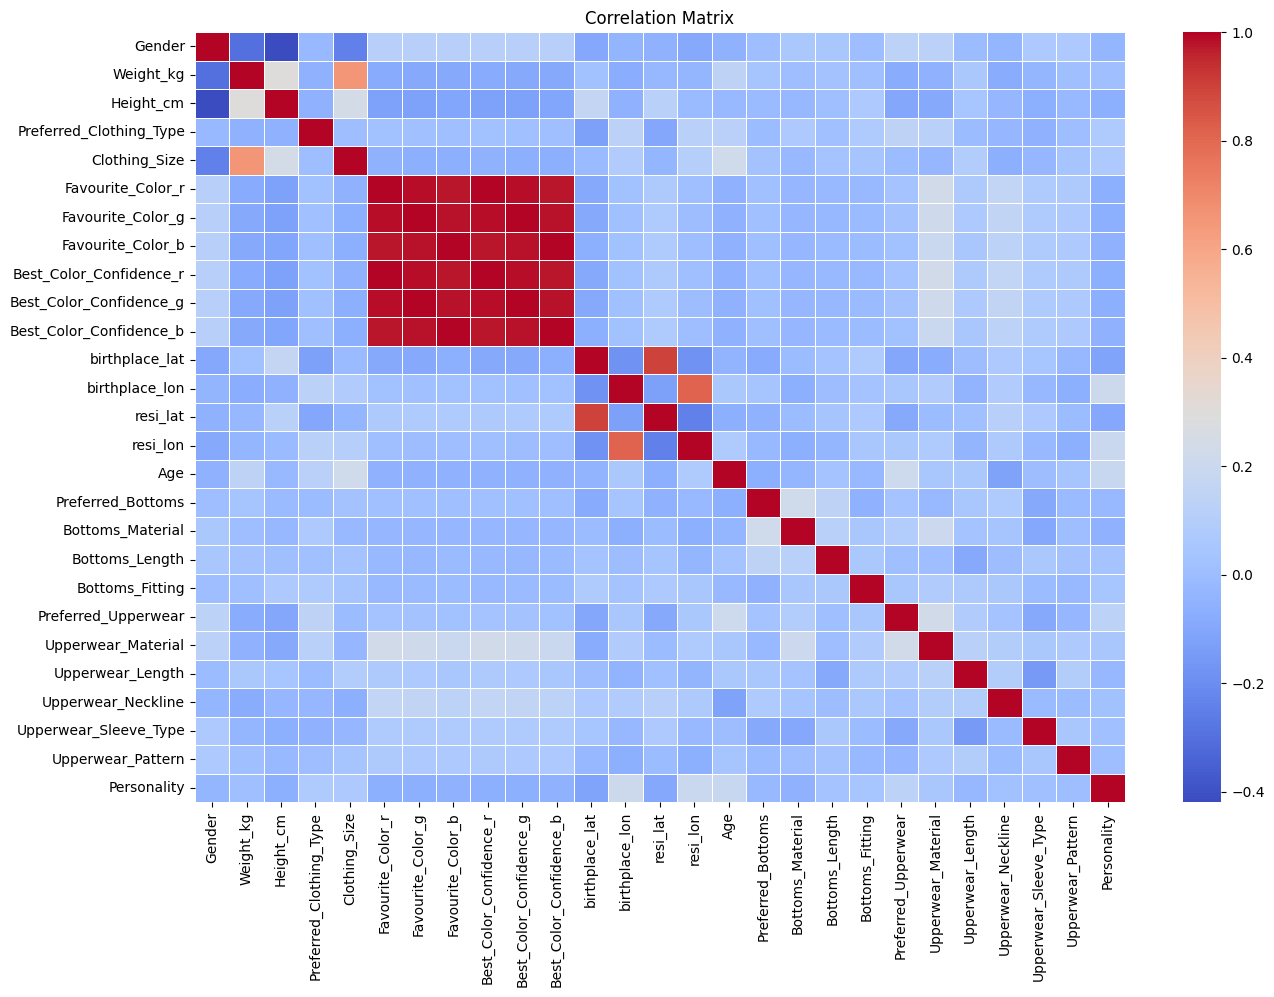

In [41]:
df_1 = df[df["Preferred_Clothing"] == 1]
df_1 = df_1[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 
                'Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
           'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern', "Personality"]]
df_1.drop_duplicates(inplace=True)

corr_matrix = df_1.corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [40]:
df_1 = df[df["Preferred_Clothing"] == 0]
df_1 = df_1[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
              'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
              'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', "Personality"]]
df_1.drop_duplicates(inplace=True)

corr_matrix = df_1.corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.save()
plt.title('Correlation Matrix')
plt.show()

In [4]:
df = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Personality', 'Clothing_Size',
        'Preferred_Clothing','Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b',
       'Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 'Preferred_Bottoms', 
        'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color_r', 'Bottoms_Color_g', 
        'Bottoms_Color_b', 'Preferred_Upperwear', 'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline', 
        'Upperwear_Sleeve_Type', 'Upperwear_Pattern', 'Upperwear_Color_r','Upperwear_Color_g','Upperwear_Color_b',
         'Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length', 
         'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern','Single_Piece_Color_r',
         'Single_Piece_Color_g', 'Single_Piece_Color_b' , 'birthplace_lat','birthplace_lon', 'resi_lat', 
         'resi_lon', 'Age']]

df.drop_duplicates(inplace=True)
df.fillna(0, inplace=True)

/Users/shrutipatkar/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shrutipatkar/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shrutipatkar/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shrutipatkar/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

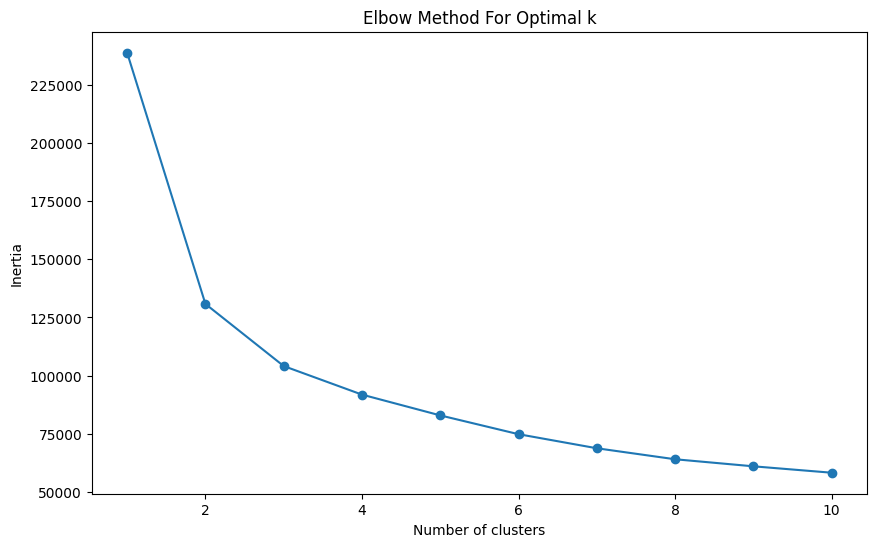

           Gender   Weight_kg   Height_cm  Preferred_Clothing_Type  \
Cluster                                                              
0        2.452736   68.064677   93.452736                 1.955224   
1        1.099888   83.921998  168.210999                 2.828844   
2        2.927184   59.063107  154.449029                 2.366505   
3        1.908367   72.800797  171.298805                 2.204781   
4        2.829634   62.519978  162.472253                 3.336848   
5        2.982249   60.625444  163.307692                 1.953452   
6        2.203497  104.797475  172.724624                 2.119961   
7        1.041970   73.176497  176.979898                 2.122819   

         Personality  Clothing_Size  Favourite_Color_r  Favourite_Color_g  \
Cluster                                                                     
0           2.189055       6.621891           0.318876           0.199415   
1           3.862514       9.131874           1.713860           0.3

/Users/shrutipatkar/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/h3/lldh0c4j02962dvm357kt4080000gn/T/ipykernel_5594/119183133.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_cluster['Cluster'] = clusters


In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample Data Loading (replace this with your actual data)
# df = pd.read_csv('path_to_your_data.csv')

# Assuming 'df' is your DataFrame and it's ready to be used directly
# If you have categorical features, convert them to numeric using pd.get_dummies or similar methods

# Normalize features for better performance

data_for_cluster = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Personality', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'Preferred_Bottoms']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_for_cluster)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal number of clusters (let's assume it's 3 from the plot)
k_optimal = 8
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to your original dataframe
data_for_cluster['Cluster'] = clusters
df['Cluster'] = clusters
# Analyze the results
print(data_for_cluster.groupby('Cluster').mean())

# Optional: Visualize the clusters if the dimensionality allows
if data_for_cluster.shape[1] <= 5:  # Simplistic check for visualization feasibility
    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='black', s=50, alpha=0.7)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, marker='*', edgecolor='black')
    plt.title('Visualization of clustered data')
    plt.xlabel('Feature 1 (scaled)')
    plt.ylabel('Feature 2 (scaled)')
    plt.show()


In [6]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import numpy as np

# Assuming X_scaled is your scaled dataset

# Estimate the bandwidth (i.e., the radius of the area considered local) automatically
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=500)

# Initialize the Mean Shift model
model = MeanShift(bandwidth=bandwidth, bin_seeding=True)

# Fit the model
model.fit(X_scaled)

# Extract cluster assignments for each data point
labels = model.labels_

# Optional: number of clusters
n_clusters_ = len(np.unique(labels))

# Output the labels and cluster centers
print("Labels:", labels)
print("Number of estimated clusters : %d" % n_clusters_)




Labels: [0 0 0 ... 0 0 0]
Number of estimated clusters : 12


In [7]:
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=500)

# Applying Mean Shift
mean_shift = MeanShift(bandwidth=bandwidth)
labels = mean_shift.fit_predict(X_scaled)

# Calculating the silhouette score
silhouette = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {silhouette}')

# Output the number of clusters
print("Number of estimated clusters :", len(set(labels)))

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)
df['Cluster'] = clusters
if len(np.unique(clusters)) > 1:  # Checking if we have more than one cluster (excluding noise)
    score = silhouette_score(X_scaled, clusters)
    print("Silhouette Score: ", score)
else:
    print("Not enough clusters to compute Silhouette Score.")

In [ ]:
"""import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Assuming X_train and y_train are already defined and properly preprocessed
# Here, X_train should be the dataset you want to cluster

# Standardize the features
data_for_cluster = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Personality', 'Clothing_Size',
        'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b',
       'Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_for_cluster)


# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your dataset characteristics
clusters = dbscan.fit_predict(X_scaled)
df['Cluster'] = clusters
# Plotting the results, ensure your dataset is 2D or reduce dimensions for visualization
plt.figure(figsize=(12, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7, edgecolor='black')

# Identify and highlight noise points
noise = clusters == -1
plt.scatter(X_scaled[noise, 0], X_scaled[noise, 1], c='red', label='Noise', s=100, edgecolor='black')

plt.title('DBSCAN Clustering Visualization')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.legend()
plt.show()

# Optionally, calculate metrics if y_train is relevant to evaluate clustering
if 'y_train' in locals():
    for i, label in enumerate(np.unique(clusters)):
        if label == -1:
            continue  # Skip noise
        label_mask = clusters == label
        mse = mean_squared_error(y_train[label_mask], clusters[label_mask])
        r2 = r2_score(y_train[label_mask], clusters[label_mask])
        print(f"Cluster {label}: MSE = {mse}, R2 = {r2}")"""


In [ ]:
pip install imbalanced-learn

In [22]:
df_resampled = df.fillna(0)

In [23]:
df_resampled

Gender  Weight_kg  Height_cm  Preferred_Clothing_Type  Personality  \
0           3         80        156                        3            3   
1           3         80        156                        3            3   
2           3         80        156                        3            3   
3           3         80        156                        3            3   
16          1         68        174                        2            2   
...       ...        ...        ...                      ...          ...   
45539       3         80        174                        3            2   
45540       1         70        180                        2            1   
45542       1         70        180                        2            1   
45544       1         70        180                        2            1   
45546       1         70        180                        2            1   

       Clothing_Size  Preferred_Clothing  Favourite_Color_r  \
0                  7                   0                255   
1                  8                   0                255   
2                  9                   0                255   
3                 10                   0                255   
16                 6                   1                  0   
...              ...                 ...                ...   
45539              9                   0                  0   
45540              9                   0                  0   
45542              9                   0                  0   
45544              9                   0                  0   
45546              9                   0                  0   

       Favourite_Color_g  Favourite_Color_b  ...  Single_Piece_Neckline  \
0                    255                  0  ...                      1   
1                    255                  0  ...                      1   
2                    255                  0  ...                      1   
3                    255                  0  ...                      1   
16                   128                  0  ...                      2   
...                  ...                ...  ...                    ...   
45539                  0                  0  ...                      4   
45540                  0                255  ...                     13   
45542                  0                  0  ...                     13   
45544                  0                255  ...                     13   
45546                  0                  0  ...                     13   

       Single_Piece_Pattern  Single_Piece_Color_r  Single_Piece_Color_g  \
0                         1                     0                     0   
1                         1                     0                     0   
2                         1                     0                     0   
3                         1                     0                     0   
16                        1                     0                     0   
...                     ...                   ...                   ...   
45539                     1                     0                     0   
45540                     3                     0                     0   
45542                     3                     0                     0   
45544                     1                     0                     0   
45546                     1                     0                     0   

       Single_Piece_Color_b  birthplace_lat  birthplace_lon   resi_lat  \
0                         0       20.593684       78.962880  55.378051   
1                         0       20.593684       78.962880  55.378051   
2                         0       20.593684       78.962880  55.378051   
3                         0       20.593684       78.962880  55.378051   
16                        0       20.593684       78.962880  55.378051   
...                     ...             ...             ...        ...   
45539

In [9]:
import pandas as pd
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

"""
# Assuming df is your dataframe and 'class' is your target feature
# Separate majority and minority classes
df_majority = df_preferred_clothing[df_preferred_clothing['Preferred_Clothing'] == 1]
df_minority = df_preferred_clothing[df_preferred_clothing['Preferred_Clothing'] == 0]

# Upsample minority class without replacement
df_minority_upsampled = resample(df_minority,
                                 replace=True,      # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class size
                                 random_state=123)  # reproducible results

# Combine the majority class with the upsampled minority class
df_combined = pd.concat([df_majority, df_minority_upsampled])"""

# Apply SMOTE
sm = SMOTE(random_state=123)
X, y = df.drop('Preferred_Clothing', axis=1), df['Preferred_Clothing']
X_res, y_res = sm.fit_resample(X, y)

# Combine resampled data back into a DataFrame
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['Preferred_Clothing'] = y_res

# Display new class counts
print(df_resampled['Preferred_Clothing'].value_counts())

1    17198
0    17198
Name: Preferred_Clothing, dtype: int64


In [13]:
#Preferred_Clothing
df_resampled.fillna(0, inplace=True)
# Perform stratified train-test split
df_preferred_clothing = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Personality', 'Clothing_Size',
        'Preferred_Clothing','Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b',
       'Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b']]
df_preferred_clothing.drop_duplicates(inplace=True)                        
X = df_preferred_clothing.drop(columns=["Preferred_Clothing"])
y = df_preferred_clothing["Preferred_Clothing"]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/h3/lldh0c4j02962dvm357kt4080000gn/T/ipykernel_5594/132136598.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preferred_clothing.drop_duplicates(inplace=True)


In [14]:
df_preferred_clothing

Gender  Weight_kg  Height_cm  Preferred_Clothing_Type  Personality  \
0           3         47        160                        2            1   
8           3        127        163                        2            2   
9           3         70        171                        3            2   
11          3         60        165                        2            2   
27          3         49        149                        2            1   
...       ...        ...        ...                      ...          ...   
18341       3         67        165                        2            2   
18343       1         70        180                        2            1   
18344       1         70        180                        2            1   
18347       3         60        170                        2            2   
18351       3         60        170                        2            2   

       Clothing_Size  Preferred_Clothing  Favourite_Color_r  \
0                  6                   1           1.000000   
8                 10                   0           1.000000   
9                  7                   0           1.000000   
11                 7                   1           1.000000   
27                 6                   1           1.000000   
...              ...                 ...                ...   
18341              8                   1           0.000000   
18343              9                   0           0.000000   
18344              9                   0           0.000000   
18347              8                   1           0.960784   
18351              9                   1           0.960784   

       Favourite_Color_g  Favourite_Color_b  Best_Color_Confidence_r  \
0               1.000000           1.000000                 1.000000   
8               0.000000           0.000000                 1.000000   
9               0.000000           0.000000                 1.000000   
11              0.752941           0.796078                 1.000000   
27              0.752941           0.796078                 1.000000   
...                  ...                ...                      ...   
18341           0.000000           0.000000                 0.000000   
18343           0.000000           1.000000                 0.000000   
18344           0.000000           0.000000                 0.000000   
18347           0.960784           0.862745                 0.960784   
18351           0.960784           0.862745                 0.960784   

       Best_Color_Confidence_g  Best_Color_Confidence_b  
0                     1.000000                 1.000000  
8                     0.000000                 0.000000  
9                     0.000000                 0.000000  
11                    0.752941                 0.796078  
27                    0.752941                 0.796078  
...                        ...                      ...  
18341                 0.000000                 0.000000  
18343                 0.000000                 1.000000  
18344                 0.000000                 0.000000  
18347                 0.960784                 0.862745  
18351                 0.960784                 0.862745  

[2788 rows x 13 columns]

In [ ]:
"""import pandas as pd
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Assuming df is your dataframe and 'class' is your target feature
# Separate majority and minority classes
df_majority = df_preferred_clothing[df_preferred_clothing['Preferred_Clothing'] == 1]
df_minority = df_preferred_clothing[df_preferred_clothing['Preferred_Clothing'] == 0]

# Upsample minority class without replacement
df_minority_upsampled = resample(df_minority,
                                 replace=True,      # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class size
                                 random_state=123)  # reproducible results

# Combine the majority class with the upsampled minority class
df_combined = pd.concat([df_majority, df_minority_upsampled])

# Apply SMOTE
sm = SMOTE(random_state=123)
X, y = df_preferred_clothing.drop('Preferred_Clothing', axis=1), df_preferred_clothing['Preferred_Clothing']
X_res, y_res = sm.fit_resample(X, y)

# Combine resampled data back into a DataFrame
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['Preferred_Clothing'] = y_res

# Display new class counts
print(df_resampled['Preferred_Clothing'].value_counts())

X = df_resampled[['birthplace_lat',
       'birthplace_lon', 'resi_lat', 'resi_lon', 'Gender',
       'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type',
       'Clothing_Size', 'Favourite_Color', 'Best_Color_Confidence',  'Age']]
y = df_resampled["Preferred_Clothing"]


# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)"""


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Logistic Regression model
# Adjust 'multi_class' if you have more than two classes
model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')


# Fit the model
model.fit(X_train_scaled, y_train.squeeze())  # using ravel() to ensure y_train is the correct shape

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.01      0.02       130
           1       0.77      1.00      0.87       424

    accuracy                           0.76       554
   macro avg       0.55      0.50      0.44       554
weighted avg       0.66      0.76      0.67       554


Confusion Matrix:
[[  1 129]
 [  2 422]]

True Positives (TP): 422
False Positives (FP): 129
True Negatives (TN): 1
False Negatives (FN): 2


/Users/shrutipatkar/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [8]:
y_train

NameError: name 'y_train' is not defined

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Make predictions
y_pred = tree_model.predict(X_test)

# Create a DataFrame to display y_test and y_pred
results_df = pd.DataFrame(y_test)

#results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Reset the index if necessary (to align the rows correctly)
results_df.reset_index(drop=True, inplace=True)
# Reset index to match y_pred (important if the indices are not aligned)
results_df.reset_index(drop=True, inplace=True)

# Add the predictions to the DataFrame
#results_df['Predicted'] = y_pred


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display the first few rows of the results
print(results_df.head())
cm = confusion_matrix(y_test, y_pred)
print(cm)

tn, fp, fn, tp = cm.ravel()

# Print true positives, false positives, true negatives, false negatives
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
"""

# Convert the color name 'blue' to its RGB representation
ann = colors.to_rgba('darkblue')
ann = np.asarray(ann)

# Normalize the RGB values to the 0-255 range
ann = (ann * 255).astype(np.uint8)

# Combine the RGB values into a single int32 value
int_value = (ann[0] << 16) + (ann[1] << 8) + ann[2]

# Display the result
print("RGB values:", ann)
print("Integer value:", int_value)

# Function to retrieve RGBA values from a 32-bit integer
def int32_to_rgba(int32_value):
    r = (int32_value >> 24) & 0xFF
    g = (int32_value >> 16) & 0xFF
    b = (int32_value >> 8) & 0xFF
    a = int32_value & 0xFF
    return np.array([r, g, b, a]) / 255

# Retrieve the RGB values
retrieved_rgb = int32_to_rgb(int_value)

# Display the result
ann, int_value, retrieved_rgb"""







In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define features and target
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Preferred_Clothing'])

# Apply a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Print true positives, false positives, true negatives, false negatives
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

True Positives (TP): 369
False Positives (FP): 90
True Negatives (TN): 1903
False Negatives (FN): 69

Accuracy: 0.9345948169477581

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1993
           1       0.80      0.84      0.82       438

    accuracy                           0.93      2431
   macro avg       0.88      0.90      0.89      2431
weighted avg       0.94      0.93      0.94      2431



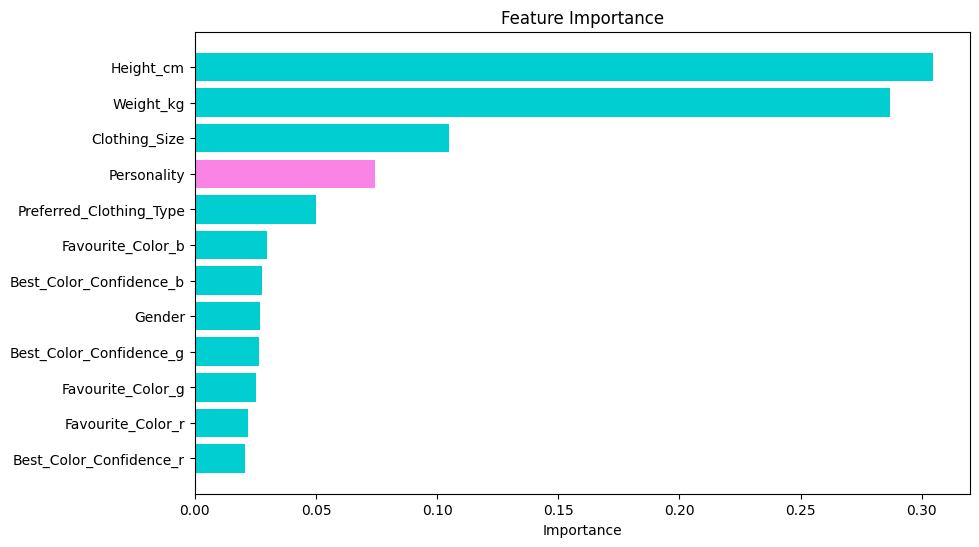

In [24]:
import matplotlib.pyplot as plt

# Fit the model
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to view the feature importances
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
ax = plt.figure(figsize=(10, 6))
bar_colors = ['#f984e5' if feature == 'Personality' else '#00ced1' for feature in features_df['Feature']]
plt.barh(features_df['Feature'], features_df['Importance'], color=bar_colors)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.savefig("test.png")
plt.show()

In [29]:
# Fit the model to get feature importances
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Define a threshold below which features will be considered unimportant
threshold = 0.010

# Find features with importance less than the threshold
unimportant_features = features_df[features_df['Importance'] < threshold]['Feature'].tolist()

# Print unimportant features
print("Unimportant features to be dropped:", unimportant_features)

# Drop these features from the training and testing datasets
X_train_dropped = X_train.drop(columns=unimportant_features)
X_test_dropped = X_test.drop(columns=unimportant_features)

# Information on the datasets after dropping features
print("Training data shape after dropping features:", X_train_dropped.shape)
print("Testing data shape after dropping features:", X_test_dropped.shape)


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

# Assuming X_train_dropped and X_test_dropped are already defined from the previous steps

# Initialize the Decision Tree classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_model.fit(X_train_dropped, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_dropped)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Unimportant features to be dropped: []
Training data shape after dropping features: (2212, 12)
Testing data shape after dropping features: (554, 12)
Accuracy: 0.8032490974729242
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.33      0.44       130
           1       0.82      0.95      0.88       424

    accuracy                           0.80       554
   macro avg       0.74      0.64      0.66       554
weighted avg       0.78      0.80      0.78       554

Confusion Matrix:
[[ 43  87]
 [ 22 402]]


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define a set of parameters to test
param_grid_rf = {
    'n_estimators': [100, 200, 250],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 3, 5],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 5],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, verbose=1, scoring='accuracy')

# Split the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train_dropped, y_train, test_size=0.2, random_state=42)

# Fit GridSearchCV
grid_search_rf.fit(X_train_rf, y_train_rf)

# The best estimator
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best accuracy found: ", grid_search_rf.best_score_)

# Use the best estimator to make predictions
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test_rf)

# Evaluate the best model found from the GridSearch
print("Classification Report:")
print(classification_report(y_test_rf, y_pred_rf))

# Print confusion matrix
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
print("Confusion Matrix:")
print(cm_rf)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best accuracy found:  0.8100766633056449
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.23      0.33        96
           1       0.82      0.96      0.88       347

    accuracy                           0.80       443
   macro avg       0.71      0.59      0.61       443
weighted avg       0.77      0.80      0.76       443

Confusion Matrix:
[[ 22  74]
 [ 15 332]]


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define features and target
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Preferred_Clothing'])

# Apply a Random Forest Classifier
rf_model = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 300 , random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Print true positives, false positives, true negatives, false negatives
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

True Positives (TP): 409
False Positives (FP): 93
True Negatives (TN): 37
False Negatives (FN): 15

Accuracy: 0.8050541516245487

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.28      0.41       130
           1       0.81      0.96      0.88       424

    accuracy                           0.81       554
   macro avg       0.76      0.62      0.64       554
weighted avg       0.79      0.81      0.77       554



In [40]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Assuming X and y are your features and target variable
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(boosting_type='dart', learning_rate=0.8, max_depth=12, n_estimators=250, num_leaves=158, subsample=0.4)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

cm = confusion_matrix(y_test, predictions)
print(cm)

tn, fp, fn, tp = cm.ravel()

# Print true positives, false positives, true negatives, false negatives
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


/Users/shrutipatkar/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:06:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "boosting_type", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 76.53%
[[ 54  76]
 [ 54 370]]
True Positives (TP): 370
False Positives (FP): 76
True Negatives (TN): 54
False Negatives (FN): 54


In [ ]:
"""# Import necessary libraries
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Assuming X and y are your datasets
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.squeeze()

# Create the SVM model using a linear kernel
model = svm.SVC(kernel='linear')

# Train the model with the training data
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Output the classification report and accuracy of the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))"""

In [37]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoost Classifier
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5)

# Train the model
model.fit(X_train, y_train, verbose=False)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


Accuracy: 78.16%
Confusion Matrix:
[[ 12 118]
 [  3 421]]
True Positives (TP): 421
False Positives (FP): 118
True Negatives (TN): 12
False Negatives (FN): 3


In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LightGBM Classifier
model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

Accuracy: 78.16%
Confusion Matrix:
[[ 17 113]
 [  8 416]]
True Positives (TP): 416
False Positives (FP): 113
True Negatives (TN): 17
False Negatives (FN): 8


In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb
lgbm_model = lgb.LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

feature_imp = pd.DataFrame({'Feature': X.columns, 'Importance': lgbm_model.feature_importances_}).sort_values(by='Importance', ascending=False)
print(feature_imp)


# Visualizing feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_imp['Feature'], feature_imp['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [ ]:
# Fit the model to get feature importances
lgbm_model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.fit(X_train, y_train).feature_importances_

# Create a DataFrame for feature importances
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Define a threshold below which features will be considered unimportant
threshold = -0.1

# Find features with importance less than the threshold
unimportant_features = features_df[features_df['Importance'] < threshold]['Feature'].tolist()

# Print unimportant features
print("Unimportant features to be dropped:", unimportant_features)

# Drop these features from the training and testing datasets
X_train_dropped_2 = X_train.drop(columns=unimportant_features)
X_test_dropped_2 = X_test.drop(columns=unimportant_features)

# Information on the datasets after dropping features
print("Training data shape after dropping features:", X_train_dropped.shape)
print("Testing data shape after dropping features:", X_test_dropped.shape)


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

# Assuming X_train_dropped and X_test_dropped are already defined from the previous steps

# Initialize the Decision Tree classifier
model = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1,
                          max_depth=5, n_estimators=100)
model.fit(X_train_dropped_2, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_dropped)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the data
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_train_dropped_2, y_train, test_size=0.2, random_state=42)

# Initialize the LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier()

# Define a dictionary containing the parameters to test
param_grid_lgb = {
    'n_estimators': [50, 100, 200, 250],
    'learning_rate': [0.01, 0.1, 0.5, 0.7, 0.8],
    'max_depth': [3, 5, 8, 10, 12],
    'num_leaves': [31, 62, 124, 136],  # Important for LightGBM
    'boosting_type': ['gbdt', 'dart'],  # Gradient Boosting Decision Tree, DART
    'subsample': [0.4,0.5,0.6, 0.8, 1.0]  # Subsample ratio of the training instance.
}

# Set up GridSearchCV
grid_search_lgb = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid_lgb, cv=3, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search_lgb.fit(X_train_lgb, y_train_lgb)

# Best parameters and best score
print("Best parameters found: ", grid_search_lgb.best_params_)
print("Best accuracy found: ", grid_search_lgb.best_score_)

# Use the best estimator to make predictions on the test set
best_estimator = grid_search_lgb.best_estimator_
predictions_lgb = best_estimator.predict(X_test_lgb)

# Evaluate the best model found from the GridSearch
accuracy = accuracy_score(y_test_lgb, predictions_lgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification Report:")
print(classification_report(y_test_lgb, predictions_lgb))

# Calculate confusion matrix
cm = confusion_matrix(y_test_lgb, predictions_lgb)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


In [39]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the LightGBM Classifier
#model = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=62, subsample=0.4)
model = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.8, max_depth=12, n_estimators=250, num_leaves=158, subsample=0.4)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


Accuracy: 80.51%
Confusion Matrix:
[[ 60  70]
 [ 38 386]]
True Positives (TP): 386
False Positives (FP): 70
True Negatives (TN): 60
False Negatives (FN): 38


In [ ]:
"""from sklearn.ensemble import StackingClassifier, RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assume X_train, X_test, y_train, y_test are already defined

# Define the base models
base_models = [
    ('random_forest', RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)),
    ('lightgbm', lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.5, max_depth=12, n_estimators=250, num_leaves=124, subsample=0.4))
]

# Define a meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, passthrough=True)

# Training the stacking model
stacking_model.fit(X_train_dropped, y_train)

# Predicting the test set results
y_pred = stacking_model.predict(X_test_dropped)

# Evaluating the stacked model
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")"""


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train RandomForest
rf_model = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 250 , random_state=42)
rf_model.fit(X_train, y_train)

# Initialize and train LightGBM
lgb_model = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.8, max_depth=12, n_estimators=250, num_leaves=158, subsample=0.4)

lgb_model.fit(X_train, y_train)

# Predict probabilities for the test set
rf_probs = rf_model.predict_proba(X_test)[:, 1]  # Assuming binary classification
lgb_probs = lgb_model.predict_proba(X_test)[:, 1]

# Blend the predictions by averaging
blended_probs = (rf_probs + lgb_probs) / 2

# Convert probabilities to final predictions based on a threshold
final_predictions = (blended_probs > 0.5).astype(int)

# Evaluate the blended model
accuracy = accuracy_score(y_test, final_predictions)
print("Blended Model Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


In [ ]:
# Predict probabilities for the test set
rf_probs = rf_model.predict_proba(X_eval)[:, 1]  # Assuming binary classification
lgb_probs = lgb_model.predict_proba(X_eval)[:, 1]

# Blend the predictions by averaging
blended_probs = (rf_probs + lgb_probs) / 2

# Convert probabilities to final predictions based on a threshold
final_predictions = (blended_probs > 0.5).astype(int)

# Evaluate the blended model
accuracy = accuracy_score(y_eval, final_predictions)
print("Blended Model Accuracy: %.2f%%" % (accuracy * 100.0))

# Calculate confusion matrix
cm = confusion_matrix(y_eval, final_predictions)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


# next columns

In [ ]:
df.columns

In [15]:
#2 piece wear
df.fillna(0, inplace=True)
# Perform stratified train-test split
df_1= df_resampled[df_resampled["Preferred_Clothing"] == 1]
df_1.drop_duplicates(inplace=True)
X = df_1[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type',
       'Personality', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b',
       'Best_Color_Confidence_r', 'Best_Color_Confidence_g',
       'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y = df_1[[
    'Preferred_Bottoms', 'Bottoms_Material',
       'Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline',
       'Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
    #,'Upperwear_Color_r','Upperwear_Color_g', 'Upperwear_Color_b','Bottoms_Color_r','Bottoms_Color_g', 'Bottoms_Color_b']]

#label_encoders = {col: LabelEncoder() for col in y.columns}

#y_1 = pd.DataFrame()
# Apply LabelEncoder to each column in y_train and y_test
#for col in y_train.columns:
#    y_1[col] = label_encoders[col].fit_transform(y[col])
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'df_resampled' is not defined

In [ ]:
df_1

In [ ]:
"""import pandas as pd
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split

# Initialize the H2O cluster
h2o.init()

# Sample data preparation
# Assuming X and y are already defined in your workspace

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset the index for X_train and y_train to ensure unique indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Concatenate X_train and y_train for H2O
combined_train = pd.concat([X_train, y_train], axis=1)

# Ensure it is a DataFrame
if isinstance(combined_train, pd.Series):
    combined_train = combined_train.to_frame().T  # Convert to DataFrame if it is a Series

# Convert pandas DataFrame to H2OFrame
h2o_train = h2o.H2OFrame(combined_train)
h2o_test = h2o.H2OFrame(X_test)

# Specify the target and feature names
target = 'Merged_Columns'  # Replace with the actual target column name from your dataset
features = [col for col in h2o_train.columns if col != target]

# Set up and train the H2O AutoML model
aml = H2OAutoML(max_models=10, seed=1, max_runtime_secs=300)
aml.train(x=features, y=target, training_frame=h2o_train)

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head())

# Predict on test data
h2o_predictions = aml.leader.predict(h2o_test)

# Optionally convert predictions to pandas DataFrame
predictions_df = h2o.as_list(h2o_predictions)

# Close the H2O cluster
h2o.shutdown(prompt=False)"""


In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X and y are already defined and y is a DataFrame
# If y is not a DataFrame, you would convert it here
if not isinstance(y, pd.DataFrame):
    y = pd.DataFrame(y, columns=[f'target_{i}' for i in range(y.shape[1])])

# Initialize dictionaries to store results
models = {}
accuracy_scores = {}
classification_reports = {}

# Loop over each target column in y_train
for column in y_train.columns:
    # Setup the classifier model for this specific target
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train[column])
    
    # Store the model
    models[column] = model
    
    # Predict on the test set
    predictions = model.predict(X_test)
    
    # Calculate accuracy for this target
    accuracy = accuracy_score(y_test[column], predictions)
    accuracy_scores[column] = accuracy
    
    # Generate classification report
    report = classification_report(y_test[column], predictions, output_dict=True, zero_division=0)
    classification_reports[column] = report
    
    # Print accuracy for each target
    print(f"Accuracy for {column}: {accuracy:.2f}")

# Calculate and print the average accuracy across all targets
average_accuracy = np.mean(list(accuracy_scores.values()))
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")"""


In [ ]:
"""from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

# Initialize the model for multi-output classification with CatBoost
cat_model = MultiOutputClassifier(CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5, verbose=False))

# Train the model
cat_model.fit(X_train, y_train)

# Make predictions
predictions = cat_model.predict(X_test)

# Calculate accuracy for each output feature and overall
accuracies = [accuracy_score(y_test.iloc[:, i], predictions[:, i]) for i in range(y_test.shape[1])]
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy:.2f}")

# Optionally, print accuracy for each target
for i, acc in enumerate(accuracies, start=1):
    print(f"Accuracy for target {i}: {acc:.2f}")"""


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y have already been defined as shown in your setup

# Perform stratified train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_classifier.predict(X_test)

# Evaluating the model - calculating accuracy for each target and overall
accuracies = [accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the accuracy and classification report for each target
for i, column in enumerate(y_train.columns):
    print(f"Accuracy for {column}: {accuracies[i]:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    #print("\n" + "-"*80 + "\n")  # This adds a line for better readability between outputs for each target

# If desired, you can still calculate and print the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define a set of parameters to test
param_grid_rf = {
    'n_estimators': [100, 200, 210],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 2, 3],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 4, 5],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=2, verbose=1, scoring='accuracy')

# Split the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train[y_train.columns[-2]], test_size=0.2, random_state=42)

# Fit GridSearchCV
grid_search_rf.fit(X_train_rf, y_train_rf)

# The best estimator
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best accuracy found: ", grid_search_rf.best_score_)

# Use the best estimator to make predictions
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test_rf)

# Evaluate the best model found from the GridSearch
print("Classification Report:")
print(classification_report(y_test_rf, y_pred_rf))

# Print confusion matrix
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
print("Confusion Matrix:")
print(cm_rf)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define a set of parameters to test
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 5]
}
for i in range(0, len(y_train.columns)):
# Define the model
    rf = RandomForestClassifier(random_state=42)

    # Initialize RandomizedSearchCV
    random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, n_iter=10, cv=3, verbose=1, scoring='accuracy', n_jobs=-1, random_state=42)

    # Split the data
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train[y_train.columns[i]], test_size=0.2, random_state=42)

    # Fit RandomizedSearchCV
    random_search_rf.fit(X_train_rf, y_train_rf)

    # The best estimator
    print("Best parameters found: ", random_search_rf.best_params_)
    print("Best accuracy found: ", random_search_rf.best_score_)
"""
# Use the best estimator to make predictions
y_pred_rf = random_search_rf.best_estimator_.predict(X_test_rf)

# Evaluate the best model found from the RandomizedSearch
print("Classification Report:")
print(classification_report(y_test_rf, y_pred_rf))

# Print confusion matrix
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
print("Confusion Matrix:")
print(cm_rf)"""


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y have already been defined as shown in your setup

# Perform stratified train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='entropy', random_state=42)
#criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_classifier.predict(X_test)

# Evaluating the model - calculating accuracy for each target and overall
accuracies = [accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the accuracy and classification report for each target
for i, column in enumerate(y_train.columns):
    print(f"Accuracy for {column}: {accuracies[i]:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    #print("\n" + "-"*80 + "\n")  # This adds a line for better readability between outputs for each target

# If desired, you can still calculate and print the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y have already been defined as shown in your setup

# Perform stratified train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, min_samples_leaf=1, criterion='entropy', random_state=42)
#'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100

# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_classifier.predict(X_test)

# Evaluating the model - calculating accuracy for each target and overall
accuracies = [accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the accuracy and classification report for each target
for i, column in enumerate(y_train.columns):
    print(f"Accuracy for {column}: {accuracies[i]:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    #print("\n" + "-"*80 + "\n")  # This adds a line for better readability between outputs for each target

# If desired, you can still calculate and print the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")


In [ ]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Assume X and y have already been defined as shown in your setup
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the base RandomForest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for RandomForest
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# Initialize the MultiOutputClassifier with RandomForest
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Initialize GridSearchCV
grid_search = GridSearchCV(multi_rf_classifier, param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best estimator
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the best model found from the GridSearch
accuracies = [accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")"""


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

y_1 = pd.DataFrame()
# Assume X and y_1 have already been defined
label_encoders = {col: LabelEncoder() for col in y.columns}
for col in y.columns:
    y_1[col] = label_encoders[col].fit_transform(y[col])
    
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.2, random_state=42)

# Initialize LabelEncoders
label_encoders = {col: LabelEncoder() for col in y_train.columns}

# Apply LabelEncoder to each column in y_train and y_test
for col in y_train.columns:
    y_train[col] = label_encoders[col].fit_transform(y_train[col])

# Initialize an XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='mlogloss')

# Wrap it in the MultiOutputClassifier
multi_xgb_classifier = MultiOutputClassifier(xgb_classifier)

# Training the classifier
multi_xgb_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_xgb_classifier.predict(X_test)

# Decode predictions back to original labels
decoded_y_pred = {col: label_encoders[col].inverse_transform(y_pred[:, i]) for i, col in enumerate(y_train.columns)}

# Evaluate the model - calculating accuracy for each target and generating reports
for i, column in enumerate(y_train.columns):
    try:
        # Decoding y_test back to original labels for comparison
        original_y_test = label_encoders[column].inverse_transform(y_test.iloc[:, i])
        accuracy = accuracy_score(original_y_test, decoded_y_pred[column])
        print(f"Accuracy for {column}: {accuracy:.2f}")
        #print(f"Classification Report for {column}:")
        #print(classification_report(original_y_test, decoded_y_pred[column], zero_division=0))
    except:
        print(f"Accuracy for {column}")
        

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Define a set of parameters to test
param_grid_xgb = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# Iterate over each target column if you have multiple targets
for i in range(0, 1):
    # Split the data for the current target
    X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_train, y_train[[y_train.columns[i]]], test_size=0.2, random_state=42)
    
    # Initialize LabelEncoders
    label_encoder = LabelEncoder()

    # Apply LabelEncoder to the column in y_train_xgb and y_test_xgb
    y_train_xgb[y_train.columns[i]] = label_encoder.fit_transform(y_train_xgb[y_train.columns[i]])
    y_test_xgb[y_train.columns[i]] = label_encoder.transform(y_test_xgb[y_train.columns[i]])
    
    
    
    # Initialize RandomizedSearchCV
    random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, n_iter=10, cv=3, verbose=1, scoring='accuracy', n_jobs=-1, random_state=42)

    # Fit RandomizedSearchCV
    random_search_xgb.fit(X_train_xgb, y_train_xgb)

    # Output the best parameters and accuracy
    print(f"Best parameters for {y_train.columns[i]}: ", random_search_xgb.cv_results_['params'])
    print(f"Best accuracy for {y_train.columns[i]}: ", random_search_xgb.cv_results_['score'])


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define a set of parameters to test
param_grid_lgb = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 5, 7, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]
}

# Iterate over each target column if you have multiple targets
for i in range((len(y_train.columns))-1, len(y_train.columns)):
    # Split the data for the current target
    X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_train, y_train[y_train.columns[i]], test_size=0.2, random_state=42)
    
    # Initialize RandomizedSearchCV
    random_search_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid_lgb, n_iter=10, cv=3, verbose=1, scoring='accuracy', n_jobs=-1, random_state=42)

    # Fit RandomizedSearchCV
    random_search_lgb.fit(X_train_lgb, y_train_lgb)

    # Output the best parameters and accuracy
    print(f"Best parameters for {y_train.columns[i]}: ", random_search_lgb.best_params_)
    print(f"Best accuracy for {y_train.columns[i]}: ", random_search_lgb.best_score_)

    # Optionally, use the best estimator to make predictions and evaluate it
    y_pred_lgb = random_search_lgb.best_estimator_.predict(X_test_lgb)
    print(f"Classification Report for {y_train.columns[i]}:")
    print(classification_report(y_test_lgb, y_pred_lgb))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_lgb, y_pred_lgb))
    print("\n" + "-"*80 + "\n")  # This adds a line for better readability between outputs for each target


In [ ]:
random_search_xgb.cv_results_['mean_test_score'],

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

y_1 = pd.DataFrame()
# Assume X and y_1 have already been defined
label_encoders = {col: LabelEncoder() for col in y.columns}
for col in y.columns:
    y_1[col] = label_encoders[col].fit_transform(y[col])
    
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.2, random_state=42)

# Initialize LabelEncoders
label_encoders = {col: LabelEncoder() for col in y_train.columns}

# Apply LabelEncoder to each column in y_train and y_test
for col in y_train.columns:
    y_train[col] = label_encoders[col].fit_transform(y_train[col])

# Initialize an XGBoost Classifier
#xgb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier = xgb.XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=10, subsample=0.9, colsample_bytree=0.9, use_label_encoder=False, eval_metric='mlogloss')
#{'subsample': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.9}

# Wrap it in the MultiOutputClassifier
multi_xgb_classifier = MultiOutputClassifier(xgb_classifier)

# Training the classifier
multi_xgb_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_xgb_classifier.predict(X_test)

# Decode predictions back to original labels
decoded_y_pred = {col: label_encoders[col].inverse_transform(y_pred[:, i]) for i, col in enumerate(y_train.columns)}

# Evaluate the model - calculating accuracy for each target and generating reports
for i, column in enumerate(y_train.columns):
    try:
        # Decoding y_test back to original labels for comparison
        original_y_test = label_encoders[column].inverse_transform(y_test.iloc[:, i])
        accuracy = accuracy_score(original_y_test, decoded_y_pred[column])
        print(f"Accuracy for {column}: {accuracy:.2f}")
        #print(f"Classification Report for {column}:")
        #print(classification_report(original_y_test, decoded_y_pred[column], zero_division=0))
    except:
        print(f"Accuracy for {column}")
        

In [ ]:
"""import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X and y_1 are predefined, and y_1 is already in a suitable numeric format for classification

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

# Wrap it in the MultiOutputClassifier
multi_lgb_classifier = MultiOutputClassifier(lgb_classifier)

# Training the classifier
multi_lgb_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_lgb_classifier.predict(X_test)

# Evaluate the model
for i, column in enumerate(y_train.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Accuracy for {column}: {accuracy:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
# If desired, you can still calculate and print the average accuracy

average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")"""


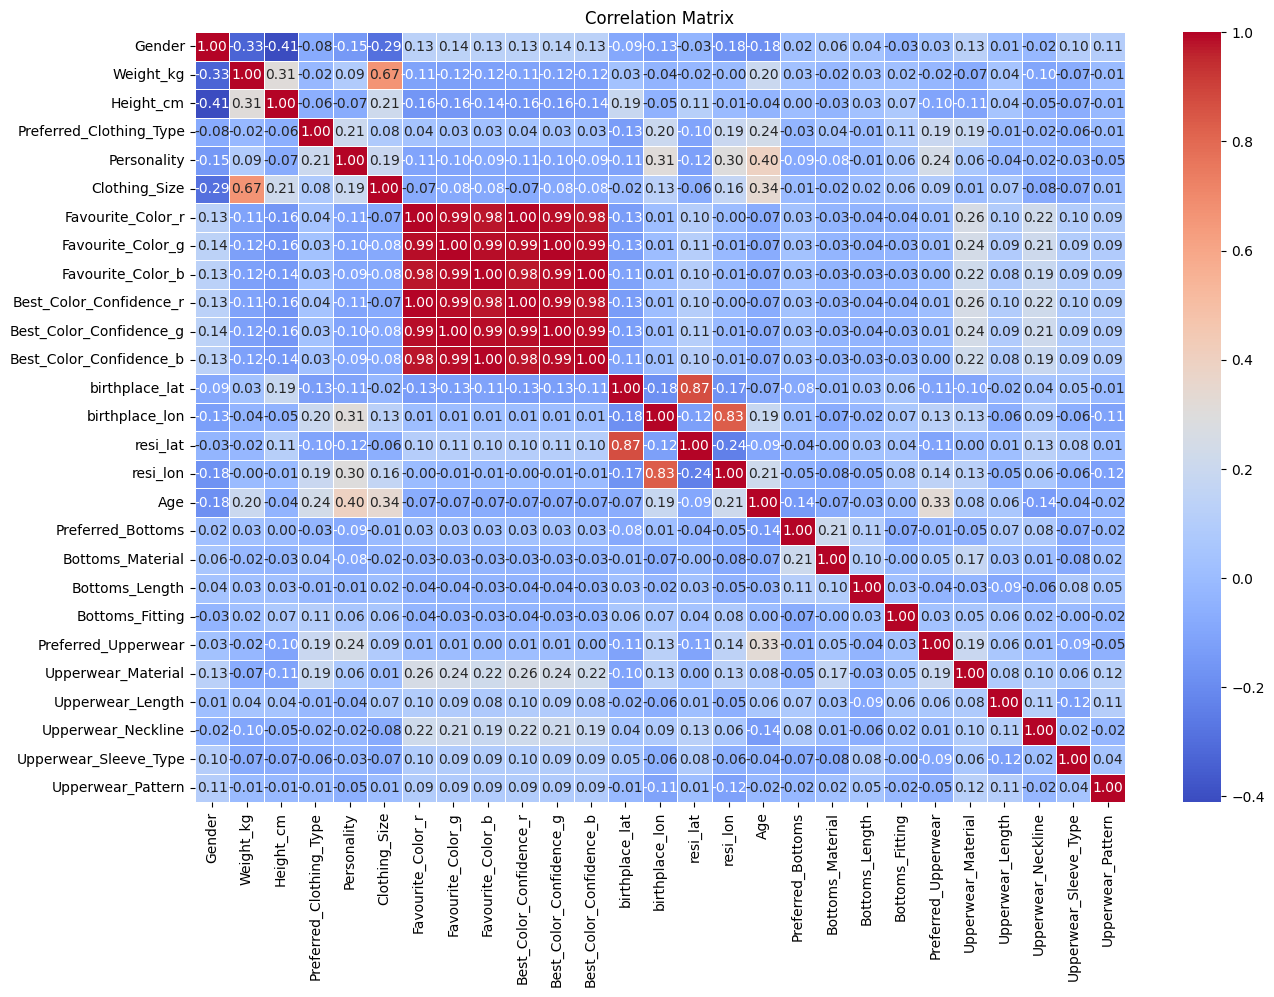

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing all the relevant columns

# Compute the correlation matrix
df_1= df[df["Preferred_Clothing"] == 1]
corr_matrix = df_1[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type',
       'Personality', 'Clothing_Size','Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b',
       'Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat', 
        'birthplace_lon', 'resi_lat', 'resi_lon', 'Age','Preferred_Bottoms', 'Bottoms_Material',
       'Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear','Upperwear_Material', 'Upperwear_Length', 
        'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern' ]].corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
"""import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X and y_1 are predefined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize CatBoost Classifier
cat_classifier = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    verbose=False
)

# Wrap it in the MultiOutputClassifier
multi_cat_classifier = MultiOutputClassifier(cat_classifier)

# Training the classifier
multi_cat_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_cat_classifier.predict(X_test)

# Check shapes
print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)

# Verify the dimensions match; if not, you might need to reshape
if y_pred.shape != y_test.shape:
    y_pred = y_pred.reshape(y_test.shape)

# Evaluate the model
for i, column in enumerate(y_train.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Accuracy for {column}: {accuracy:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))"""


In [ ]:
"""from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y_1 are predefined, and y_1 contains labels in a numeric format

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)

# Wrap it in the MultiOutputClassifier
multi_dt_classifier = MultiOutputClassifier(dt_classifier)

# Training the classifier
multi_dt_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_dt_classifier.predict(X_test)

# Evaluate the model
for i, column in enumerate(y_train.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Accuracy for {column}: {accuracy:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))"""


In [ ]:
"""from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Data preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the base models
base_models = [
    ('catboost', cb.CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, verbose=False)),
    ('xgboost', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='mlogloss')),
    ('lightgbm', lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)),
    ('decision_tree', DecisionTreeClassifier(max_depth=3))
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking ensemble
stacking_ensemble = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Training the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Making predictions
y_pred = stacking_ensemble.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
#print("Classification Report:")
#print(classification_report(y_test, y_pred)) """


In [ ]:
"""import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)),
    ('lgb', LGBMClassifier(n_estimators=10, learning_rate=0.1, max_depth=5)),
    ('cat', CatBoostClassifier(iterations=10,learning_rate=0.1,depth=5,verbose=False))
]

# MultiOutput with stacking
multioutput_model = MultiOutputClassifier(StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()))

# Train model
multioutput_model.fit(X_train, y_train)

# Predict on test data
y_pred = multioutput_model.predict(X_test)

# Evaluate model
for i in range(y_test.shape[1]):
    accuracy = accuracy_score(y_test[:, i], y_pred[:, i])
    print(f"Accuracy for output {i}: {accuracy:.2f}")

# If you need a more customized handling of each class's predictions or more control over the stacking process,
# you might need to adjust the way you train/test each model or configure the final estimator."""


In [ ]:
"""from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X and y are already defined, and y is a DataFrame with multiple targets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model_final = LogisticRegression()

# Fit the RandomForest and XGBoost models
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

# Get predictions/probabilities for the validation set
rf_predictions = model_rf.predict_proba(X_val)
xgb_predictions = model_xgb.predict_proba(X_val)

# Convert predictions to a suitable input array for the final model
# Assuming both models predict probabilities for each class in each column of y
rf_features = np.hstack([preds[:, :, 1] for preds in rf_predictions])  # Taking the probability of the positive class
xgb_features = np.hstack([preds[:, :, 1] for preds in xgb_predictions])

# Stack features from both models
stacked_features = np.hstack([rf_features, xgb_features])

# Fit the final model on these new features
model_final.fit(stacked_features, y_val)

# Prediction using the final model
final_predictions = model_final.predict(stacked_features)"""


In [ ]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y have already been defined as shown in your setup
# Assume X and y_1 have already been defined
# Initialize LabelEncoders
label_encoders = {col: LabelEncoder() for col in y.columns}

y_1 = pd.DataFrame()
# Apply LabelEncoder to each column in y_train and y_test
for col in y_train.columns:
    y_1[col] = label_encoders[col].fit_transform(y[col])
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred_random = multi_rf_classifier.predict(X_test)

# Evaluating the model - calculating accuracy for each target and overall
accuracies = [accuracy_score(y_test.iloc[:, i], y_pred_random[:, i]) for i in range(y_test.shape[1])]

# Printing the accuracy and classification report for each target
for i, column in enumerate(y_train.columns):
    print(f"Accuracy for {column}: {accuracies[i]:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    #print("\n" + "-"*80 + "\n")  # This adds a line for better readability between outputs for each target

# If desired, you can still calculate and print the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")"""


In [ ]:
"""from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Perform train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.2, random_state=42)

# Initialize LabelEncoders
label_encoders = {col: LabelEncoder() for col in y_train.columns}

# Apply LabelEncoder to each column in y_train and y_test
for col in y_train.columns:
    y_train[col] = label_encoders[col].fit_transform(y_train[col])

# Initialize an XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='mlogloss')

# Wrap it in the MultiOutputClassifier
multi_xgb_classifier = MultiOutputClassifier(xgb_classifier)

# Training the classifier
multi_xgb_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_xgb_classifier.predict(X_test)

# Decode predictions back to original labels
decoded_y_pred = {col: label_encoders[col].inverse_transform(y_pred[:, i]) for i, col in enumerate(y_train.columns)}

# Evaluate the model - calculating accuracy for each target and generating reports
for i, column in enumerate(y_train.columns):
    try:
        # Decoding y_test back to original labels for comparison
        original_y_test = label_encoders[column].inverse_transform(y_test.iloc[:, i])
        accuracy = accuracy_score(original_y_test, decoded_y_pred[column])
        print(f"Accuracy for {column}: {accuracy:.2f}")
        #print(f"Classification Report for {column}:")
        #print(classification_report(original_y_test, decoded_y_pred[column], zero_division=0))
    except:
        print(column)"""


In [ ]:
"""import pandas as pd

# Assuming `decoded_y_pred` is a dictionary where each value is a numpy array
# Convert the dictionary of arrays into a DataFrame
column_name = ["xgboost_"+col for col in decoded_y_pred.keys()]
df_decoded_y_pred = pd.DataFrame(decoded_y_pred, columns = column_name)

# Convert the numpy array of random forest predictions into a DataFrame
# Assume `y_pred_random` has the same columns as `y_test`
column_name = ["random_"+col for col in y_test.columns]
df_y_pred_random = pd.DataFrame(y_pred_random, columns=column_name)

# Now concatenate all DataFrames side by side
result_df = pd.concat([y_test.reset_index(drop=True), 
                       df_decoded_y_pred.reset_index(drop=True), 
                       df_y_pred_random.reset_index(drop=True)], axis=1)

# Renaming columns to re

# Display the combined DataFrame
print(result_df.head())"""

In [ ]:
"""X_2 = result_df.drop(columns= [
    'Preferred_Bottoms', 'Bottoms_Material', 'Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color', 
    'Preferred_Upperwear', 'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type', 
    'Upperwear_Pattern', 'Upperwear_Print_Type', 'Upperwear_Color'
])
y_2 = result_df[[
    'Preferred_Bottoms', 'Bottoms_Material', 'Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color', 
    'Preferred_Upperwear', 'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type', 
    'Upperwear_Pattern', 'Upperwear_Print_Type', 'Upperwear_Color'
]]



# Perform stratified train-test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)"""


In [ ]:
"""import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize CatBoost Classifier
cat_classifier = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    verbose=False
)

# Wrap it in the MultiOutputClassifier
multi_cat_classifier = MultiOutputClassifier(cat_classifier)

# Training the classifier
multi_cat_classifier.fit(X_train_2, y_train_2)

# Predicting the test set results
y_pred = multi_cat_classifier.predict(X_test_2)

# Check shapes
print("y_pred shape:", y_pred_2.shape)
print("y_test shape:", y_test_2.shape)

# Verify the dimensions match; if not, you might need to reshape
if y_pred_2.shape != y_test_2.shape:
    y_pred_2 = y_pred_2.reshape(y_test.shape)

# Evaluate the model
for i, column in enumerate(y_train_2.columns):
    accuracy = accuracy_score(y_test_2.iloc[:, i], y_pred_2[:, i])
    print(f"Accuracy for {column}: {accuracy:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))"""


# final

In [ ]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, and y_test are already defined and y_train has a column "Preferred_Bottoms"

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(max_depth=7, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42)

# Train the classifier on the first column of the target data
rf_classifier.fit(X_train, y_train['Preferred_Bottoms'])  # Train on the first target column

# Predict on the test dataset
y_pred_col = rf_classifier.predict(X_test)

# Calculate accuracy by comparing to the corresponding test data
accuracy = accuracy_score(y_test['Preferred_Bottoms'], y_pred_col)

print("Accuracy on the first target column:", accuracy)

# If y_pred is not already defined, we need to prepare it to store our predictions:
# Assuming y_test is a DataFrame and you want to keep the structure
y_pred = y_test.copy()
y_pred['Preferred_Bottoms'] = y_pred_col  # Replace the actual test values with the predictions"""


In [ ]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, and y_test are already defined
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train['Preferred_Bottoms'])

# Best estimator found by GridSearch
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred_col = best_rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test['Preferred_Bottoms'], y_pred_col)

print("Accuracy on the first target column with tuned parameters:", accuracy)"""


In [ ]:
"""from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target dataset respectively
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y['Preferred_Bottoms'], test_size=0.2, random_state=42)  # Change y['Preferred_Bottoms'] to the target column as needed

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)  # Using a linear kernel and regularization parameter C=1

# Train the classifier
svm_classifier.fit(X_train, y_train[])

# Predict on the test dataset
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the SVM model:", accuracy)"""


In [ ]:
df_resampled.columns

In [ ]:
#2 piece wear
df_resampled.fillna(0, inplace=True)
# Perform stratified train-test split
df_11= df_resampled[df_resampled["Preferred_Clothing"] == 1]
df_11 = df_11[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 
           'resi_lat', 'resi_lon', 'Age', 'Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
df_11.drop_duplicates(inplace=True)
X = df_11[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
           'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 
           'resi_lat', 'resi_lon', 'Age']]
y = df_11[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
    #,'Upperwear_Color_r','Upperwear_Color_g', 'Upperwear_Color_b','Bottoms_Color_r','Bottoms_Color_g', 'Bottoms_Color_b']]

#label_encoders = {col: LabelEncoder() for col in y.columns}

#y_1 = pd.DataFrame()
# Apply LabelEncoder to each column in y_train and y_test
#for col in y_train.columns:
#    y_1[col] = label_encoders[col].fit_transform(y[col])
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Normalize features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[2])),
    Dense(y_train.shape[1])
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Encode categorical data if necessary
for column in y.columns:
    y[column] = LabelEncoder().fit_transform(y[column])

# Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Sigmoid because of multi-label classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Example of loading data - assuming X and y are already defined and suitable for regression
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=250, max_depth=15, min_samples_split=3, min_samples_leaf=2, random_state=42)

# Wrap it in the MultiOutputRegressor
multi_rf_regressor = MultiOutputRegressor(rf_regressor)

# Training the regressor
multi_rf_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_regressor.predict(X_test)

# Evaluating the model - calculating MSE for each target and overall
mse_scores = [mean_squared_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the MSE for each target
for i, column in enumerate(y_train.columns):
    print(f"MSE for {column}: {mse_scores[i]:.2f}")

# Calculate and print the average MSE
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average MSE across all targets: {average_mse:.2f}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Example of loading data - assuming X and y are already defined and suitable for regression
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=3, min_samples_leaf=2, random_state=42)

# Wrap it in the MultiOutputRegressor
multi_rf_regressor = MultiOutputRegressor(rf_regressor)

# Training the regressor
multi_rf_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_regressor.predict(X_test)

# Evaluating the model - calculating MSE for each target and overall
mse_scores = [mean_squared_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the MSE for each target
for i, column in enumerate(y_train.columns):
    print(f"MSE for {column}: {mse_scores[i]:.2f}")

# Calculate and print the average MSE
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average MSE across all targets: {average_mse:.2f}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
rf_regressor = RandomForestRegressor(random_state=42)

# Define a set of parameters to test
param_grid_rf = {
    'n_estimators': [100, 200, 210],  # Number of trees in the forest
    'max_depth': [None, 1, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 4],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=5, verbose=1, scoring='neg_mean_squared_error')
for col in ['Upperwear_Color_b']:
    # Split the data
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train[col], test_size=0.2, random_state=42)

    # Fit GridSearchCV
    grid_search_rf.fit(X_train_rf, y_train_rf)

    # The best estimator
    print("Best parameters found for", col, ":", grid_search_rf.best_params_)
    print("Best MSE found for", col, ":", -grid_search_rf.best_score_)

    # Use the best estimator to make predictions
    y_pred_rf = grid_search_rf.best_estimator_.predict(X_test_rf)

    # Evaluate the best model found from the GridSearch
    print(f"Evaluation for {col}:")
    print("Mean Squared Error:", mean_squared_error(y_test_rf, y_pred_rf))
    print("R2 Score:", r2_score(y_test_rf, y_pred_rf))
    print("\n" + "-"*80 + "\n")


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

# Sample dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the XGBoost regressor with MultiOutputRegressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
multi_xgb_regressor = MultiOutputRegressor(xgb_regressor)

# Fit the model
multi_xgb_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred = multi_xgb_regressor.predict(X_test)
mse_scores = [mean_squared_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
average_mse = sum(mse_scores) / len(mse_scores)

# Printing the MSE for each target
for i, column in enumerate(y_train.columns):
    print(f"MSE for {column}: {mse_scores[i]:.2f}")
print("Average MSE:", average_mse)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

# Assume you have already defined X and y with RGB target values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LightGBM regressor with MultiOutputRegressor
lgb_regressor = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
multi_lgb_regressor = MultiOutputRegressor(lgb_regressor)

# Fit the model
multi_lgb_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred = multi_lgb_regressor.predict(X_test)
mse_scores = [mean_squared_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
average_mse = sum(mse_scores) / len(mse_scores)

# Printing the MSE for each target
for i, column in enumerate(y_train.columns):
    print(f"MSE for {column}: {mse_scores[i]:.2f}")
print("Average MSE:", average_mse)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
lgb_regressor = lgb.LGBMRegressor(random_state=42)

# Define a set of parameters to test
param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [-1, 5, 10, 15],
    'num_leaves': [31, 62, 128],
    'min_child_samples': [20, 40, 60],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize GridSearchCV
grid_search_lgb = GridSearchCV(estimator=lgb_regressor, param_grid=param_grid_lgb, cv=5, verbose=1, scoring='neg_mean_squared_error')

# Assuming X_train and y_train are defined and the target columns are specified
columns = ['Upperwear_Color_b', 
           'Bottoms_Color_b', ]

for col in columns:
    # Split the data
    X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_train, y_train[col], test_size=0.2, random_state=42)

    # Fit GridSearchCV
    grid_search_lgb.fit(X_train_lgb, y_train_lgb)

    # The best estimator and MSE
    print("Best parameters found for", col, ":", grid_search_lgb.best_params_)
    print("Best MSE found for", col, ":", -grid_search_lgb.best_score_)

    # Use the best estimator to make predictions
    y_pred_lgb = grid_search_lgb.best_estimator_.predict(X_test_lgb)

    # Evaluate the best model found from the GridSearch
    print(f"Evaluation for {col}:")
    print("Mean Squared Error:", mean_squared_error(y_test_lgb, y_pred_lgb))
    print("R2 Score:", r2_score(y_test_lgb, y_pred_lgb))
    print("\n" + "-"*80 + "\n")


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

# Assume you have already defined X and y with RGB target values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LightGBM regressor with MultiOutputRegressor
lgb_regressor = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=10, min_child_samples=60, 
                                  num_leaves=62, subsample=0.8,random_state=42)

#'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 60, 'n_estimators': 300, 'num_leaves': 62, 'subsample': 0.8
multi_lgb_regressor = MultiOutputRegressor(lgb_regressor)

# Fit the model
multi_lgb_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred = multi_lgb_regressor.predict(X_test)
mse_scores = [mean_squared_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
average_mse = sum(mse_scores) / len(mse_scores)

# Printing the MSE for each target
for i, column in enumerate(y_train.columns):
    print(f"MSE for {column}: {mse_scores[i]:.2f}")
print("Average MSE:", average_mse)


In [ ]:
--NotebookApp.iopub_data_rate_limit=1.0e10

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y have already been defined as shown in your setup

# Perform stratified train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, min_samples_leaf=1, criterion='entropy', random_state=42)
#'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100

# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_classifier.predict(X_test)

# Evaluating the model - calculating accuracy for each target and overall
accuracies = [accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the accuracy and classification report for each target
for i, column in enumerate(y_train.columns):
    print(f"Accuracy for {column}: {accuracies[i]:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    #print("\n" + "-"*80 + "\n")  # This adds a line for better readability between outputs for each target

# If desired, you can still calculate and print the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")


In [19]:
df.columns

Index(['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type',
       'Personality', 'Clothing_Size', 'Preferred_Clothing',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b',
       'Best_Color_Confidence_r', 'Best_Color_Confidence_g',
       'Best_Color_Confidence_b', 'Preferred_Bottoms', 'Bottoms_Material',
       'Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color_r',
       'Bottoms_Color_g', 'Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline',
       'Upperwear_Sleeve_Type', 'Upperwear_Pattern', 'Upperwear_Color_r',
       'Upperwear_Color_g', 'Upperwear_Color_b', 'Favourite_Single_Piece',
       'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
       'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern',
       'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b',
       'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age'],

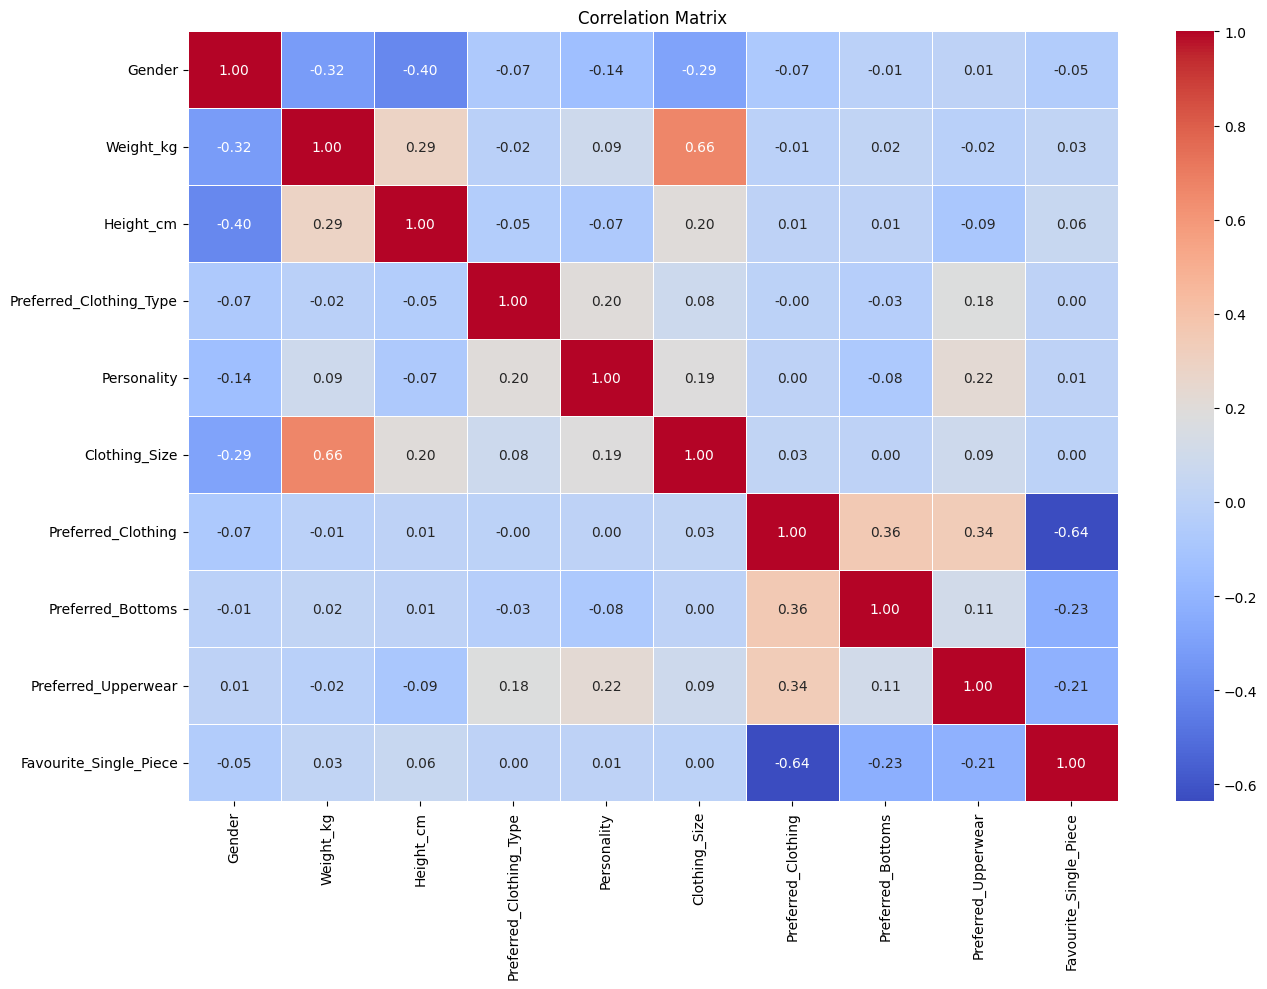

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing all the relevant columns

# Compute the correlation matrix
corr_matrix = df[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type',
       'Personality', 'Clothing_Size', 'Preferred_Clothing', 'Preferred_Bottoms', 'Preferred_Upperwear',
        'Favourite_Single_Piece',]].corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Generate synthetic data for demonstration (replace with your actual dataset)
# Assume RGB values range between 0 and 255
data_size = 1000
time_steps = 5  # number of timesteps to look back for predicting the next RGB
X = np.random.randint(0, 256, size=(data_size, 3))  # Random RGB values
y = X[1:]  # Predict the next RGB value based on previous

# Preparing input data for LSTM
X_lstm = np.array([X[i:i+time_steps].flatten() for i in range(len(X) - time_steps)])
y_lstm = y[time_steps:]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_lstm_scaled = scaler.fit_transform(X_lstm)
y_lstm_scaled = scaler.fit_transform(y_lstm)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_lstm_scaled, y_lstm_scaled, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], time_steps, 3))
X_test = X_test.reshape((X_test.shape[0], time_steps, 3))

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, 3)),
    Dense(3)  # output layer with 3 units for R, G, B
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on Test Set: {mse}")


In [ ]:
import tensorflow

In [ ]:
pip install tensorflow

In [ ]:
pip install tensorflow-metal

In [ ]:
conda create -n tf python=3.9

In [ ]:
conda activate tf

In [ ]:
conda install -c apple tensorflow-deps

In [ ]:
pip install tensorflow-macos

In [ ]:
df_2= df_resampled[df_resampled["Preferred_Clothing"] == 0]
df_2 = df_2[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
        'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 
        'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 
         'Single_Piece_Length','Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
df_2.drop_duplicates(inplace=True)

X = df_2[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type','Personality', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
        'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 
        'resi_lat', 'resi_lon', 'Age']]
y = df_2[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
          'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]

#label_encoders = {col: LabelEncoder() for col in y.columns}

#y_1 = pd.DataFrame()
# Apply LabelEncoder to each column in y_train and y_test
#for col in y_train.columns:
#    y_1[col] = label_encoders[col].fit_transform(y[col])
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
"""import pandas as pd
from sklearn.utils import resample

# Assuming df_2 is your DataFrame and 'Single_Piece_Material' is the target feature
X = df_2.drop('Single_Piece_Material', axis=1)
y = df_2['Single_Piece_Material']

# Combine them back for resampling
df = pd.concat([X, y], axis=1)

# Separating classes
class_counts = y.value_counts()
max_size = class_counts.max()

# List to hold the resampled dataframes
list_resampled = []

for class_index, group in df.groupby('Single_Piece_Material'):
    resampled = resample(group,
                         replace=True,     # Sample with replacement
                         n_samples=max_size,    # Match the number of samples in the majority class
                         random_state=42)   # Reproducible results
    list_resampled.append(resampled)

df_resampled = pd.concat(list_resampled)

# Now df_resampled is the balanced dataset
df_resampled.drop_duplicates(inplace=True)
X = df_resampled[['birthplace_lat',
       'birthplace_lon', 'resi_lat', 'resi_lon', 'Gender',
       'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type',
       'Clothing_Size', 'Favourite_Color', 'Best_Color_Confidence',  'Age',
       'Preferred_Clothing']]
y = df_resampled[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
          'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern', 'Single_Piece_Color']]

#label_encoders = {col: LabelEncoder() for col in y.columns}

#y_1 = pd.DataFrame()
# Apply LabelEncoder to each column in y_train and y_test
#for col in y_train.columns:
#    y_1[col] = label_encoders[col].fit_transform(y[col])
# Perform stratified train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)"""


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y have already been defined as shown in your setup

# Perform stratified train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_classifier.predict(X_test)

# Evaluating the model - calculating accuracy for each target and overall
accuracies = [accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the accuracy and classification report for each target
for i, column in enumerate(y_train.columns):
    print(f"Accuracy for {column}: {accuracies[i]:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    #print("\n" + "-"*80 + "\n")  # This adds a line for better readability between outputs for each target

# If desired, you can still calculate and print the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define a set of parameters to test
param_grid_rf = {
    'n_estimators': [100, 200, 210],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 2, 3],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 4, 5],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=2, verbose=1, scoring='accuracy')
for col in y_train.columns:
    # Split the data
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train[col], test_size=0.2, random_state=42)

    # Fit GridSearchCV
    grid_search_rf.fit(X_train_rf, y_train_rf)

    # The best estimator
    print("Best parameters found: ", grid_search_rf.best_params_)
    print("Best accuracy found: ", grid_search_rf.best_score_)
"""
# Use the best estimator to make predictions
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test_rf)

# Evaluate the best model found from the GridSearch
print("Classification Report:")
print(classification_report(y_test_rf, y_pred_rf))

# Print confusion matrix
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
print("Confusion Matrix:")
print(cm_rf)"""


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y have already been defined as shown in your setup

# Perform stratified train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split= 2, n_estimators=200, random_state=42)

# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_classifier.predict(X_test)

# Evaluating the model - calculating accuracy for each target and overall
accuracies = [accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the accuracy and classification report for each target
for i, column in enumerate(y_train.columns):
    print(f"Accuracy for {column}: {accuracies[i]:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    #print("\n" + "-"*80 + "\n")  # This adds a line for better readability between outputs for each target

# If desired, you can still calculate and print the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y have already been defined as shown in your setup

# Perform stratified train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_samples_split= 2, n_estimators=200, random_state=42)

# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_classifier.predict(X_test)

# Evaluating the model - calculating accuracy for each target and overall
accuracies = [accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the accuracy and classification report for each target
for i, column in enumerate(y_train.columns):
    print(f"Accuracy for {column}: {accuracies[i]:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
    #print("\n" + "-"*80 + "\n")  # This adds a line for better readability between outputs for each target

# If desired, you can still calculate and print the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

y_1 = pd.DataFrame()
# Assume X and y_1 have already been defined
label_encoders = {col: LabelEncoder() for col in y.columns}
for col in y.columns:
    y_1[col] = label_encoders[col].fit_transform(y[col])
    
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.2, random_state=42)

# Initialize LabelEncoders
label_encoders = {col: LabelEncoder() for col in y_train.columns}

# Apply LabelEncoder to each column in y_train and y_test
for col in y_train.columns:
    y_train[col] = label_encoders[col].fit_transform(y_train[col])

# Initialize an XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='mlogloss')

# Wrap it in the MultiOutputClassifier
multi_xgb_classifier = MultiOutputClassifier(xgb_classifier)

# Training the classifier
multi_xgb_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_xgb_classifier.predict(X_test)

# Decode predictions back to original labels
decoded_y_pred = {col: label_encoders[col].inverse_transform(y_pred[:, i]) for i, col in enumerate(y_train.columns)}

# Evaluate the model - calculating accuracy for each target and generating reports
for i, column in enumerate(y_train.columns):
    try:
        # Decoding y_test back to original labels for comparison
        original_y_test = label_encoders[column].inverse_transform(y_test.iloc[:, i])
        accuracy = accuracy_score(original_y_test, decoded_y_pred[column])
        print(f"Accuracy for {column}: {accuracy:.2f}")
        #print(f"Classification Report for {column}:")
        #print(classification_report(original_y_test, decoded_y_pred[column], zero_division=0))
    except:
        print(f"Accuracy for {column}")
    


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X and y_1 are predefined, and y_1 is already in a suitable numeric format for classification

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

# Wrap it in the MultiOutputClassifier
multi_lgb_classifier = MultiOutputClassifier(lgb_classifier)

# Training the classifier
multi_lgb_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_lgb_classifier.predict(X_test)

# Evaluate the model
for i, column in enumerate(y_train.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Accuracy for {column}: {accuracy:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
# If desired, you can still calculate and print the average accuracy

average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
lgb = LGBMClassifier(random_state=42)

# Define a set of parameters to test
param_grid_lgb = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 5, 7, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]}

# Initialize GridSearchCV
random_search_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid_lgb, n_iter=10, cv=3, verbose=1, scoring='accuracy', n_jobs=-1, random_state=42)

# Assuming X_train and y_train are defined and y_train is a DataFrame with multiple target columns
for col in y_train.columns:
    # Split the data
    # Initialize RandomizedSearchCV
    
    # Fit RandomizedSearchCV
    random_search_lgb.fit(X_train_lgb, y_train_lgb)

    # Output the best parameters and accuracy
    print(f"Best parameters for {y_train.columns[i]}: ", random_search_lgb.best_params_)
    print(f"Best accuracy for {y_train.columns[i]}: ", random_search_lgb.best_score_)



In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X and y_1 are predefined, and y_1 is already in a suitable numeric format for classification

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(subsample= 0.6, n_estimators= 250, max_depth=10, learning_rate= 0.1, colsample_bytree=0.8)

# Wrap it in the MultiOutputClassifier
multi_lgb_classifier = MultiOutputClassifier(lgb_classifier)

# Training the classifier
multi_lgb_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_lgb_classifier.predict(X_test)

# Evaluate the model
for i, column in enumerate(y_train.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Accuracy for {column}: {accuracy:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))
# If desired, you can still calculate and print the average accuracy

average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")


In [ ]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X and y_1 are predefined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize CatBoost Classifier
cat_classifier = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    verbose=False
)

# Wrap it in the MultiOutputClassifier
multi_cat_classifier = MultiOutputClassifier(cat_classifier)

# Training the classifier
multi_cat_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_cat_classifier.predict(X_test)

# Check shapes
print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)

# Verify the dimensions match; if not, you might need to reshape
if y_pred.shape != y_test.shape:
    y_pred = y_pred.reshape(y_test.shape)

# Evaluate the model
for i, column in enumerate(y_train.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Accuracy for {column}: {accuracy:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume X and y_1 are predefined, and y_1 contains labels in a numeric format

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)

# Wrap it in the MultiOutputClassifier
multi_dt_classifier = MultiOutputClassifier(dt_classifier)

# Training the classifier
multi_dt_classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_dt_classifier.predict(X_test)

# Evaluate the model
for i, column in enumerate(y_train.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Accuracy for {column}: {accuracy:.2f}")
    #print(f"Classification Report for {column}:")
    #print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))


In [ ]:
df_22= df_resampled[df_resampled["Preferred_Clothing"] == 0]
df_22 = df_22[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
        'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 
        'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece','Single_Piece_Color_r','Single_Piece_Color_g', 'Single_Piece_Color_b']]
df_22.drop_duplicates(inplace=True)

X = df_22[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
        'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 
        'resi_lat', 'resi_lon', 'Age']]
y = df_22[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]

#label_encoders = {col: LabelEncoder() for col in y.columns}

#y_1 = pd.DataFrame()
# Apply LabelEncoder to each column in y_train and y_test
#for col in y_train.columns:
#    y_1[col] = label_encoders[col].fit_transform(y[col])
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Example of loading data - assuming X and y are already defined and suitable for regression
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=3, min_samples_leaf=1, random_state=42)

# Wrap it in the MultiOutputRegressor
multi_rf_regressor = MultiOutputRegressor(rf_regressor)

# Training the regressor
multi_rf_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_regressor.predict(X_test)

# Evaluating the model - calculating MSE for each target and overall
mse_scores = [mean_squared_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the MSE for each target
for i, column in enumerate(y_train.columns):
    print(f"MSE for {column}: {mse_scores[i]:.2f}")

# Calculate and print the average MSE
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average MSE across all targets: {average_mse:.2f}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
rf_regressor = RandomForestRegressor(random_state=42)

# Define a set of parameters to test
param_grid_rf = {
    'n_estimators': [100, 200, 210],  # Number of trees in the forest
    'max_depth': [None, 1, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 4],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=2, verbose=1, scoring='neg_mean_squared_error')
for col in ['Bottoms_Color_b']:
    # Split the data
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train[col], test_size=0.2, random_state=42)

    # Fit GridSearchCV
    grid_search_rf.fit(X_train_rf, y_train_rf)

    # The best estimator
    print("Best parameters found for", col, ":", grid_search_rf.best_params_)
    print("Best MSE found for", col, ":", -grid_search_rf.best_score_)

    # Use the best estimator to make predictions
    y_pred_rf = grid_search_rf.best_estimator_.predict(X_test_rf)

    # Evaluate the best model found from the GridSearch
    print(f"Evaluation for {col}:")
    print("Mean Squared Error:", mean_squared_error(y_test_rf, y_pred_rf))
    print("R2 Score:", r2_score(y_test_rf, y_pred_rf))
    print("\n" + "-"*80 + "\n")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Example of loading data - assuming X and y are already defined and suitable for regression
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=250, max_depth=None, min_samples_split=2, min_samples_leaf=5, random_state=42)

# Wrap it in the MultiOutputRegressor
multi_rf_regressor = MultiOutputRegressor(rf_regressor)

# Training the regressor
multi_rf_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_rf_regressor.predict(X_test)

# Evaluating the model - calculating MSE for each target and overall
mse_scores = [mean_squared_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the MSE for each target
for i, column in enumerate(y_train.columns):
    print(f"MSE for {column}: {mse_scores[i]:.2f}")

# Calculate and print the average MSE
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average MSE across all targets: {average_mse:.2f}")

In [ ]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming X and y have already been defined and are suitable for regression tasks
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a LightGBM Regressor
lgb_regressor = lgb.LGBMRegressor(n_estimators=250, learning_rate=0.1, max_depth=10, subsample=0.6, colsample_bytree=0.8, random_state=42)
# Wrap it in the MultiOutputRegressor
multi_lgb_regressor = MultiOutputRegressor(lgb_regressor)

# Training the regressor
multi_lgb_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = multi_lgb_regressor.predict(X_test)

# Evaluating the model - calculating MSE for each target and overall
mse_scores = [mean_squared_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Printing the MSE for each target
for i, column in enumerate(y_train.columns):
    print(f'MSE for {column}: {mse_scores[i]:.2f}')

# Calculate and print the average MSE
average_mse = sum(mse_scores) / len(mse_scores)
print(f'Average MSE across all targets: {average_mse:.2f}')


In [ ]:
# Load the RandomForest model
rf_model_loaded = load('random_forest_model.joblib')

# Load the LightGBM model
lgb_model_loaded = load('lightgbm_model.joblib')

# Example of using loaded models for prediction
# Assume X_new is new data you want to predict
rf_probs_loaded = rf_model_loaded.predict_proba(X_new)[:, 1]
lgb_probs_loaded = lgb_model_loaded.predict_proba(X_new)[:, 1]

# Blend the predictions by averaging (as before)
blended_probs_loaded = (rf_probs_loaded + lgb_probs_loaded) / 2
final_predictions_loaded = (blended_probs_loaded > 0.5).astype(int)

In [ ]:
# Load the MultiOutputClassifier
multi_xgb_classifier_loaded = load('multi_output_xgb_classifier.joblib')

# Assuming X_new is new data on which you want to make predictions
y_pred_loaded = multi_xgb_classifier_loaded.predict(X_new)

# Optionally, you may want to decode these predictions if they are encoded
decoded_y_pred_loaded = {col: label_encoders[col].inverse_transform(y_pred_loaded[:, i]) 
                         for i, col in enumerate(y_encoded.columns)}

In [ ]:
# Assuming X_train is your training data and has been properly prepared

# Calculate the number of features
input_features = X_train.shape[1]  # Adjust X_train to your dataset variable name

# Initialize the tuner and perform hyperparameter tuning
tuner = kt.Hyperband(lambda hp: build_model(hp, input_features),
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test),
             callbacks=[keras.callbacks.EarlyStopping(patience=1)])


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_model(hp, input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))  # Adjusted to take input_shape dynamically

    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(0.2))
    
    # Dynamically add more layers based on the tuning
    for i in range(hp.Int('layers', 1, 3)):
        model.add(Dense(units=hp_units, activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

    model.add(Dense(10, activation='softmax'))  # Output layer size for classification (adjust based on your needs)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

# Prepare your data: Assuming X_color_twopiece_train and y_color_twopiece_train are already defined

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define a dictionary of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_color_twopiece_train, y_color_twopiece_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score (negative MSE) found: ", grid_search.best_score_)

# Retrieve the best estimator to make predictions
best_rf = grid_search.best_estimator_

# Predicting the Test set results using the best estimator
y_pred = best_rf.predict(X_color_twopiece_test)

# Evaluating the model using test data
mse = mean_squared_error(y_color_twopiece_test, y_pred)
r2 = r2_score(y_color_twopiece_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Save the best model
dump(best_rf, 'best_random_forest_regressor_model.joblib')

print("Model training, hyperparameter tuning, and evaluation are complete. The best model has been saved.")
